In [1]:
import numpy as np
from csv import reader

from matplotlib import pyplot as plt
from sklearn import metrics

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels \
    import RBF, WhiteKernel, RationalQuadratic, ExpSineSquared, DotProduct 


In [2]:
# Load a CSV file
def load_csv(filename):
  file = open(filename, 'r')
  lines = reader(file)
  dataset = list(lines)
  return dataset

In [3]:
filename =  'train_data_big.csv'
dataset = load_csv(filename)

In [4]:
print('Loaded data file {0} with {1} rows and {2} columns').format(filename, len(dataset),
len(dataset[0]))

Loaded data file train_data_big.csv with 3351168 rows and 12 columns


In [5]:
filename1 =  'labels_data_big.csv'
dataset1 = load_csv(filename1)
print('Loaded data file {0} with {1} rows and {2} columns').format(filename1, len(dataset1),
len(dataset1[0]))

Loaded data file labels_data_big.csv with 3351168 rows and 1 columns


In [6]:
X1= np.asarray(dataset)[:,:]
X2=np.asarray(dataset1)[:,:]
X1array=np.concatenate((X1, X2), axis=1)
print X1array.shape #X1 array es la matriu de totes les comptes té 13 columnes.

(3351168, 13)


In [7]:
zero_accounts=np.sum(np.where((np.abs(X1array[:,:-1].astype(float))<=1e-05),1,0),axis=1)
zero_accounts[0:30]

array([ 3,  0,  0, 11,  8,  6, 11, 10,  0,  9,  6, 11, 11, 11, 11,  9, 11,
        6, 11,  7, 10, 11, 10,  5, 11,  6, 11, 12, 10, 10])

In [8]:
from collections import Counter
print Counter(zero_accounts)
zerosdecom=Counter(zero_accounts)
zerosdecom1=[zerosdecom[i] for i in np.arange(13)]

Counter({11: 992108, 10: 500957, 0: 359508, 9: 287009, 8: 225553, 7: 183299, 6: 146958, 4: 124984, 5: 118625, 12: 107245, 1: 105842, 3: 102927, 2: 96153})


7.59795808506


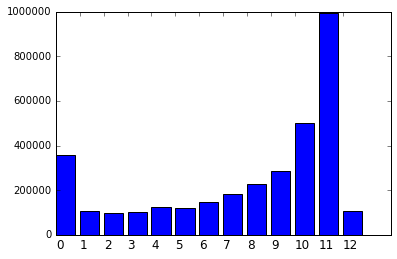

<function matplotlib.pyplot.show>

In [9]:
#Plotting the distribution of zeros
print zero_accounts.mean()
plt.bar(np.arange(13),zerosdecom1)
plt.xticks(np.arange(13),horizontalalignment='left',fontsize=12)

plt.figure(figsize=(10,10))
plt.show()
plt.figure()
plt.show

In [10]:
#Cleaning data, we drop accounts with 12 0's
wrk_accounts = zero_accounts<12
accountclean=X1array.astype(float)[wrk_accounts==True]
accountclean.shape

(3243923, 13)

In [11]:
print accountclean[44]
accountclean[0][12]

[   0.    0.    0.    0.    0.    0.    0. -300.    0.    0.    0.    0.
    0.]


-4200.0

## Dynamic Time Warping 

We want to begin the process of clusteritzation, buf before we have to provide a definition of similarity bewtween each account. Dynamic time warping finds the optimal non-linear alignment between two time series. The Euclidean distances between alignments are then much less susceptable to pessimistic similarity measurements due to distortion in the time axis. There is a price to pay for this, however, because dynamic time warping is quadratic in the length of the time series used. Note that small values for the distance between two time series implies more similarity.

In [12]:
import random
N=10000
numaccountsclust=np.asarray(list(map(lambda _: random.choice(accountclean), range(N))))
print numaccountsclust.shape

(10000, 13)


In [13]:
print len(numaccountsclust)

10000


In [12]:
def DTWDistance(s1, s2):
    DTW={}
    
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])
    return np.sqrt(DTW[len(s1)-1, len(s2)-1])

In [13]:
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return np.sqrt(LB_sum)

Let's build a matrix containing the similarities between 2.000 bank accounts.

In [16]:
#Treiem el valor al mes 13
data1=numaccountsclust[:,:-1]
print data1.shape

(10000, 12)


In [17]:
print len(data1)


10000


In [18]:
num_clust=20
centroids=random.sample(data1,num_clust)
print 'Centroides inicials :\n'
print '\n'.join(str(p) for p in centroids)
counter=0
num_iter=1
for n in range(num_iter):
    counter+=1
    #print counter
    assignments={}
    #assign data points to clusters
    for ind,i in enumerate(data1):
        min_dist=float('inf')
        closest_clust=None
        for c_ind,j in enumerate(centroids):
            if LB_Keogh(i,j,5)<min_dist:
                cur_dist=DTWDistance(i,j)
                if cur_dist<min_dist:
                    min_dist=cur_dist
                    closest_clust=c_ind
        if closest_clust in assignments:
            assignments[closest_clust].append(ind)
        else:
            assignments[closest_clust]=[]
print "\nThe assignments are the following \n"
for i in np.arange(num_clust):
    print "Cluster ",i,len(assignments[i])
#print assignments[0],'\n\n',assignments[1],'\n\n',assignments[2],'\n\n',assignments[3],'\n\n'


print "Busquem el millor centroide de cada cluster\n"
centroidscent=np.zeros((num_clust))
distot=np.zeros((num_clust))
for l in np.arange(num_clust):
    minimdistcentr=float('inf')
    closestcentr=0
    print "Cluster;",l
    for k in np.arange(len(assignments[l])):
        distcent=0
        for q in np.arange(len(assignments[l])):
            distcent+=DTWDistance(data1[assignments[l][k]],data1[assignments[l][q]])
        if distcent<minimdistcentr:
            minimdistcentr=distcent
            #print minimdistcentr
            closestcentr=assignments[l][k]
            #print closestcentr
    print minimdistcentr
    print closestcentr
    centroidscent[l]=closestcentr
    distot[l]=minimdistcentr
print "Els centroides finals son les comptes:",centroidscent
print "Les respectives distances són:",distot

    

Centroides inicials :

[-241. -186. -260. -195. -366. -116. -111. -163. -152. -288. -165. -110.]
[-160. -115. -106. -262.    0. -132. -174. -106. -106. -106. -106. -106.]
[  0.   0.   0.   0.   0.   0.   0. -94.   0.   0.   0.   0.]
[   0.    0.    0.    0.    0.    0.    0.    0. -409.    0.    0.    0.]
[-12130.      0.      0.      0.      0.      0.  -1499.  -2597.  -3048.
      0.      0.      0.]
[   0.  -17.    0.    0.    0.    0.    0.    0. -233.    0.    0.    0.]
[ -20.    0.    0.    0.    0. -419. -391. -589.    0.    0.    0.    0.]
[ 0.  5.  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.]
[ -21.    0.  -18.   -5.    0.  -13.  -72.    0.  -14.  -49.   -7. -128.]
[-100.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[-764.    0.    0.    0. -758.    0.    0.    0.    0.    0.    0.    0.]
[-108.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
[ 0.  0.  0.  0. -9.  0.  0.  0.  0.  0.  0.  0.]
[ 1336.  1336.  2672.  1336.  1368.  1336.  1336. 

[-300. -350. -300. -550. -250. -350. -200. -350. -290. -400. -450. -300.]
[ -76.  -45.  -95. -186.  -32. -231. -101.  -67. -153. -165. -141. -110.]
[   0.    0.    0.    0.    0.    0.    0.    0.    0.    0. -110.    0.]
[   0.    0.    0.    0.    0.  -19.    0.    0.    0.    0. -517.    0.]
[     0. -50000.      0.      0.      0.      0.      0.      0.      0.
      0.      0.      0.]
[   0.  -17.    0.    0.    0.    0.    0.    0. -233.    0.    0.    0.]
[ -29.    0.    0.    0.    0.  -51. -457. -695.    0.    0.    0.    0.]
[  50.    0.    0.    0.    0.    0.    0.    0.    0.    0.  200.    0.]
[ -21.    0.  -18.   -5.    0.  -13.  -72.    0.  -14.  -49.   -7. -128.]
[-79.   0.   0.   0.   0.  -8.   0.   0.   0.   0.   0.   0.]
[ -712.  -465.     0.     0.  -484.   -52.   -97.   -58.  -467. -1758.
     0.   -53.]
[-148.    0.    0.    0.    0.    0.    0.    0.    0.    0.  -48.    0.]
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. -14.   0.]
[ 1469.  1890.   938.  3

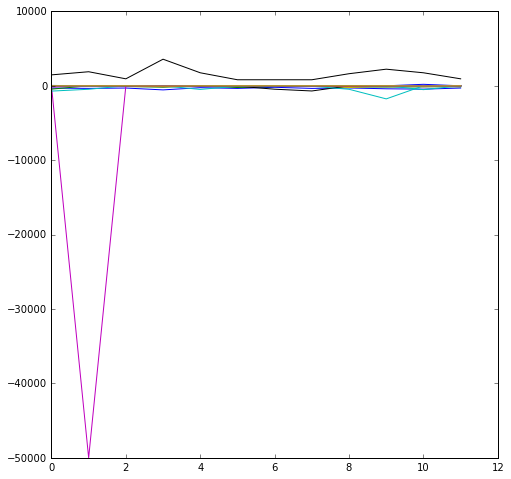

In [19]:
finalcentroids={}
plt.figure(figsize=(8,8))
for i in np.arange(num_clust):
    print data1[centroidscent[i].astype(int)]
    finalcentroids[i]=data1[centroidscent[i].astype(int)]
    plt.plot(data1[centroidscent[i].astype(int)])

plt.show()

In [14]:
clustersarraydef=np.zeros((20,12))
clustersarraydef[0]=np.array([-300., -350., -300., -550., -250., -350., -200., -350., -290., -400., -450., -300.])
clustersarraydef[1]=np.array([ -76.,  -45.,  -95., -186.,  -32., -231., -101.,  -67., -153., -165., -141., -110.])
clustersarraydef[2]=np.array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -110.,    0.])
clustersarraydef[3]=np.array([   0.,    0.,    0.,    0.,    0.,  -19.,    0.,    0.,    0.,    0., -517.,    0.])
clustersarraydef[4]=np.array([     0., -50000.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
      0.,      0.,      0.])
clustersarraydef[5]=np.array([   0.,  -17.,    0.,    0.,   0.,    0.,    0.,    0., -233.,    0.,    0.,    0.])
clustersarraydef[6]=np.array([ -29.,    0.,    0.,    0.,    0.,  -51., -457., -695.,    0.,    0.,    0.,    0.])
clustersarraydef[7]=np.array([  50.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  200.,    0.])
clustersarraydef[8]=np.array([ -21.,    0.,  -18.,   -5.,    0.,  -13.,  -72.,    0.,  -14.,  -49.,   -7., -128.])
clustersarraydef[9]=np.array([-79.,   0.,   0.,   0.,   0.,  -8.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef[10]=np.array([ -712.,  -465.,     0.,     0.,  -484.,   -52.,   -97.,   -58.,  -467., -1758.,
     0.,   -53.])
clustersarraydef[11]=np.array([-148.,    0.,    0.,    0.,    0.,   0.,    0.,    0.,    0.,    0.,  -48.,    0.])
clustersarraydef[12]=np.array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -14.,   0.])
clustersarraydef[13]=np.array([ 1469.,  1890.,   938.,  3575.,  1750.,   812.,   812.,   812.,  1625.,  2234.,
  1750.,   938.])
clustersarraydef[14]=np.array([ -5.,   0.,   0.,   0.,   0.,  -5.,   0.,   0.,   0.,   0., -10.,   0.])
clustersarraydef[15]=np.array([-446.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.])
clustersarraydef[16]=np.array([ -25.,  -69.,    0., -107.,    0.,    0.,    0.,    0.,  -86.,    0.,    0.,    0.])
clustersarraydef[17]=np.array([  0., -45.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])
clustersarraydef[18]=np.array([-28.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., -25.,   0.])
clustersarraydef[19]=np.array([ -7.,   0.,   0., -37.,   0.,   0.,   0.,   0.,   0.,   0., -37.,   0.])



In [15]:
num_clust=20
assignmentsclus={}
assignmentsclus[0]=[]
assignmentsclus[1]=[]
assignmentsclus[2]=[]
assignmentsclus[3]=[]
assignmentsclus[4]=[]
assignmentsclus[5]=[]
assignmentsclus[6]=[]
assignmentsclus[7]=[]
assignmentsclus[8]=[]
assignmentsclus[9]=[]
assignmentsclus[10]=[]
assignmentsclus[11]=[]
assignmentsclus[12]=[]
assignmentsclus[13]=[]
assignmentsclus[14]=[]
assignmentsclus[15]=[]
assignmentsclus[16]=[]
assignmentsclus[17]=[]
assignmentsclus[18]=[]
assignmentsclus[19]=[]
for i in np.arange(25000):
    minimdistcentrclus=float('inf')
    clusternum=None
    for j in np.arange(num_clust):
        distanceclust=DTWDistance(accountclean[i][:-1],clustersarraydef[j][:])
        if distanceclust<minimdistcentrclus:
            minimdistcentrclus=distanceclust
            clusternum=j
    if clusternum in assignmentsclus:
        assignmentsclus[clusternum].append(i)
    #else:
        #assignmentsclus[clusternum]=[]

#print assignmentsclus

In [16]:
print len(assignmentsclus[0])
print len(assignmentsclus[1])
print len(assignmentsclus[2])
print len(assignmentsclus[3])
print len(assignmentsclus[4])
print len(assignmentsclus[5])
print len(assignmentsclus[6])
print len(assignmentsclus[7])
print len(assignmentsclus[8])
print len(assignmentsclus[9])
print len(assignmentsclus[10])
print len(assignmentsclus[11])
print len(assignmentsclus[12])
print len(assignmentsclus[13])
print len(assignmentsclus[14])
print len(assignmentsclus[15])
print len(assignmentsclus[16])
print len(assignmentsclus[17])
print len(assignmentsclus[18])
print len(assignmentsclus[19])

1023
1108
1647
1139
128
1561
407
2666
1066
297
1214
573
2163
1092
2657
261
1316
2000
1030
1652


In [22]:
len(assignmentsclus[0])+len(assignmentsclus[1])+len(assignmentsclus[2])+len(assignmentsclus[3])+len(assignmentsclus[4])+len(assignmentsclus[5])+len(assignmentsclus[6])+len(assignmentsclus[7])+len(assignmentsclus[8])+len(assignmentsclus[9])+len(assignmentsclus[10])+len(assignmentsclus[11])+len(assignmentsclus[12])+len(assignmentsclus[13])+len(assignmentsclus[14])+len(assignmentsclus[15])+len(assignmentsclus[16])+len(assignmentsclus[17])+len(assignmentsclus[18])+len(assignmentsclus[19])

25000

In [18]:
#np.arange(accountclean.shape[0])
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

def regressionaccounts(n_folds,accountsreg,quant,gp,clusternum):

    #quant=accountcluster1.shape[0]
    a=np.arange(12)+1 #vector del 1 al 12
    a=a.reshape(-1,1)
    xs=np.arange(13,14,1).reshape(-1,1) #vector que conte el 13
    compt=0
    compt1=0
    compt2=0
    compt3=0
    compt4=0
    errort=0
    denom=0
    j=0
    lambd=10
    ypredopt={}
    errorrmse=0
    errormae=0
    #n_folds=3
    for i in np.arange(quant):
        kf=cross_validation.KFold(n=a.shape[0], n_folds=n_folds, shuffle=False, random_state=0)
        #yhat = accountclean[i].copy()
        error=0
        #print "Iteracio:",i
        gp = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
        j=0
        lml=np.zeros((n_folds,1))
        ypredopt=np.zeros((n_folds,1))
        sigma=np.zeros((n_folds,1))
        for train_index, test_index in kf:
            X_train, X_test = a[train_index], a[test_index]
            y_train, y_test = accountsreg[i][train_index], accountsreg[i][test_index]
            if j!=0:
                kernel_gpml=gp.kernel_
           #    print kernel_gpml
                gp = GaussianProcessRegressor(kernel=kernel_gpml, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
            gp.fit(X_train, y_train)
            #yhat[test_index]= gp.predict(X_test)
            #print("GPML kernel: %s" % gp.kernel_)
            lml[j]=gp.log_marginal_likelihood(gp.kernel_.theta)
            ypredopt[j],sigma[j]=gp.predict(xs, return_std=True)
            j+=1
        #lml1=lml.reshape(1,-1)
        likelibest=np.argmax(lml)
        #print likelibest
        y_pred=ypredopt[likelibest]
        #sigmapred=sigma[likelibest]
        sigmapred=sigma.max()
        #print accountcluster1[i][12], y_pred
        #print y_pred-sigmapred,y_pred+sigmapred
        if (accountsreg[i][12]<0 and y_pred<0) or (accountsreg[i][12]>0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt+=1
        if (accountsreg[i][12]<=0 and y_pred<0) or (accountsreg[i][12]>=0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt1+=1
        if (accountsreg[i][12]<=(y_pred+sigmapred)) and ((accountsreg[i][12]>=(y_pred-sigmapred))) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt2+=1
        if (accountsreg[i][12]<=(y_pred+1.9600*sigmapred)) and ((accountsreg[i][12]>=(y_pred-1.9600*sigmapred))) or (np.abs((accountsreg[i][12]-y_pred))<=1e-1):
            compt3+=1
        if (accountsreg[i][12]<0 and y_pred<0) or (accountsreg[i][12]>0 and y_pred>0) or (np.abs((accountsreg[i][12]-y_pred))<=30):
            compt4+=1
        if (accountsreg[i][12]>(y_pred+1.9600*sigmapred)) or ((accountsreg[i][12]<(y_pred-1.9600*sigmapred))):
            print "Iteracio:",i
            print accountsreg[i][12], y_pred
            print y_pred-sigmapred,y_pred+sigmapred
            print y_pred-1.9600*sigmapred,y_pred+1.9600*sigmapred
            print DTWDistance(accountsreg[i][0:12],clustersarraydef[clusternum][:])
        error=np.abs(y_pred-accountsreg[i][12])
        denom=np.sum(np.abs(np.asarray([t - s for s, t in zip(accountsreg[i], accountsreg[i][1:12])][:]))) #naive
        errorrmse+=error**2
        errormae+=error
        errort+=error/float((denom/float(11))+lambd)
        #print '\n'
    mae=errormae/float(quant)
    mase=errort/float(quant)
    rmse=np.sqrt(errorrmse/float(quant)) 
    print 'La predicció de compte en negatiu en predicció i real correctes és de:',compt/float(quant)
    print 'La predicció de compte en negatiu en predicció i real o 0 correctes és de:',compt1/float(quant)
    print 'La predicció de compte esta compresa en la zona determinada:',compt2/float(quant)
    print 'La predicció de compte ens permet assegurar el signe final:',compt3/float(quant)
    print 'Comptes signe',compt4/float(quant)
    print 'The Mean Absolute Scaled error is',mase 
    print 'The MAE error is',mae
    print 'The RMSE is',rmse
    return mase

(1023, 13)


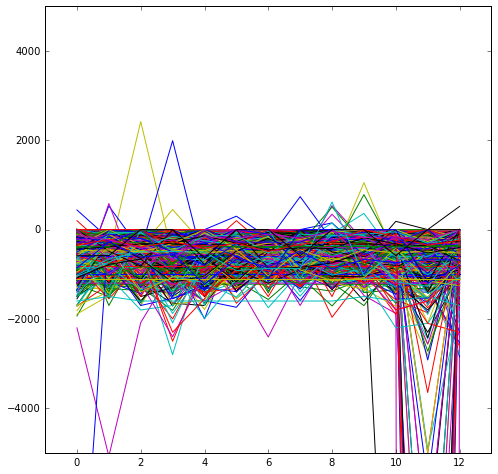

Iteracio: 37
-1324.0 [-482.74962542]
[-752.49374218] [-213.00550867]
[-1011.44809426] [ 45.94884341]
691.803440292
Iteracio: 51
-758.0 [-536.25]
[-612.97344087] [-459.52655913]
[-686.62794411] [-385.87205589]
712.166413137
Iteracio: 52
-910.0 [-306.2041237]
[-460.83560731] [-151.57264009]
[-609.28183157] [-3.12641583]
445.196585791
Iteracio: 56
-1400.0 [-488.75]
[-843.78300804] [-133.71699196]
[-1184.61469576] [ 207.11469576]
990.050503762
Iteracio: 79
-1250.0 [-463.75]
[-683.6789536] [-243.8210464]
[-894.81074906] [-32.68925094]
999.499874937
Iteracio: 115
-576.0 [-328.125]
[-444.32626652] [-211.92373348]
[-555.87948237] [-100.37051763]
213.742836137
Iteracio: 139
0.0 [-975.]
[-1286.99900472] [-663.00099528]
[-1586.51804926] [-363.48195074]
2384.65930481
Iteracio: 169
-824.0 [-340.625]
[-566.82293653] [-114.42706347]
[-783.9729556] [ 102.7229556]
574.442338273
Iteracio: 173
-1430.0 [-337.5]
[-655.24380951] [-19.75619049]
[-960.27786664] [ 285.27786664]
848.35134231
Iteracio: 206
-663.

array([ 0.77996778])

In [80]:
#Llegim les comptes del 1er cluster
accountcluster1=np.zeros((len(assignmentsclus[0]),13))
for i in np.arange(len(assignmentsclus[0])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster1[i]=accountclean[assignmentsclus[0][i].astype(int)]
print accountcluster1.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster1.shape[0]):
        plt.plot(accountcluster1[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1050.0**2 * RBF(length_scale=70.0)  # long term smooth rising trend
k2 = 20.0**2 * RBF(length_scale=10.0) *ExpSineSquared(length_scale=20.0, periodicity=4.0)+0.001  # seasonal component
# medium term irregularity
k3 = 0.5**2* RationalQuadratic(length_scale=1., alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini= k1+k2+k3+k4


gp1 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-4,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster1,accountcluster1.shape[0],gp1,0)

In [30]:
print accountcluster1[1005]
print accountcluster1[960]
print accountcluster1[868]
print accountcluster1[816]

[  0.00000000e+00   0.00000000e+00   8.00000000e+00   2.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   3.00000000e+00
   9.11870000e+04]
[   0.    0.    0.    0.    0.   85.  120.    0.    0.    0.    0.    0.
  105.]
[-3. -1. -2. -2. -1. -5. -1. -6. -2. -3. -3. -3.  0.]
[  0.   0.   0.   0.   0.   4.   0.   0.   0.   0.   0.   0.  26.]


(1108, 13)


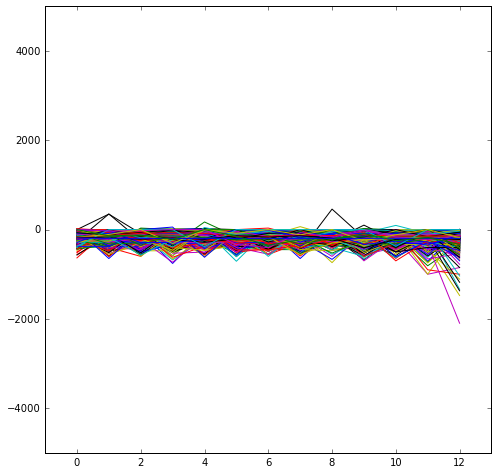

Iteracio: 2
-368.0 [-152.625]
[-258.36117886] [-46.88882114]
[-359.86791057] [ 54.61791057]
244.564919807
Iteracio: 32
-476.0 [-121.875]
[-172.34031551] [-71.40968449]
[-220.7870184] [-22.96298161]
181.3367034
Iteracio: 52
-401.0 [-127.01199198]
[-187.5645455] [-66.45943846]
[-245.69499688] [-8.32898707]
202.165773562
Iteracio: 62
-290.0 [-110.87499948]
[-138.98832554] [-82.76167341]
[-165.97711856] [-55.77288039]
155.791527369
Iteracio: 105
-469.0 [-137.50009627]
[-238.00350799] [-36.99668455]
[-334.48678324] [ 59.4865907]
340.737435572
Iteracio: 109
-68.0 [-104.62500005]
[-118.82392232] [-90.42607778]
[-132.4548877] [-76.7951124]
175.638833975
Iteracio: 131
-380.0 [-105.]
[-203.99494491] [-6.00505509]
[-299.03009203] [ 89.03009203]
192.080712202
Iteracio: 133
-482.0 [-82.37499762]
[-185.69340574] [ 20.94341051]
[-284.87907754] [ 120.12908231]
239.797831516
Iteracio: 135
-312.0 [-126.62501092]
[-189.40320254] [-63.84681931]
[-249.67026649] [-3.57975536]
162.545378279
Iteracio: 138
-23

Iteracio: 946
-347.0 [ 42.43338102]
[-41.13947321] [ 126.00623525]
[-121.36941327] [ 206.23617531]
219.383226341
Iteracio: 951
-383.0 [-101.50004048]
[-185.25405226] [-17.7460287]
[-265.65790358] [ 62.65782262]
181.146349673
Iteracio: 973
-287.0 [-51.87499907]
[-144.50328633] [ 40.75328819]
[-233.42644209] [ 129.67644396]
212.14617602
Iteracio: 1007
-400.0 [-125.29348008]
[-252.82671485] [ 2.23975469]
[-375.25862022] [ 124.67166006]
534.044941929
Iteracio: 1010
-338.0 [-166.49988049]
[-247.05217144] [-85.94758954]
[-324.38237075] [-8.61739023]
217.531606899
Iteracio: 1028
0.0 [-116.7500226]
[-163.1739969] [-70.32604831]
[-207.74101222] [-25.75903298]
159.260792413
Iteracio: 1049
-620.0 [-98.75]
[-234.62121939] [ 37.12121939]
[-365.05759] [ 167.55759]
287.579554211
Iteracio: 1082
-90.0 [-211.89200883]
[-270.22062904] [-153.56338862]
[-326.21610444] [-97.56791322]
216.212858082
Iteracio: 1085
-467.0 [-161.75000841]
[-292.47963842] [-31.02037841]
[-417.98008322] [ 94.4800664]
335.95237757

array([ 0.73564605])

In [81]:
#Llegim les comptes del 2on cluster
accountcluster2=np.zeros((len(assignmentsclus[1]),13))
for i in np.arange(len(assignmentsclus[1])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster2[i]=accountclean[assignmentsclus[1][i].astype(int)]
print accountcluster2.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster2.shape[0]):
        plt.plot(accountcluster2[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 170.0**2 * RBF(length_scale=23.0)  # long term smooth rising trend
k2 =  10.0**2 * RBF(length_scale=0.6) # seasonal component
# medium term irregularity
#k2 = 5.0*ExpSineSquared(length_scale=5.0, periodicity=3.0)*(30.0**2 * RBF(length_scale=10.0))
k3 = 3.5**2* RationalQuadratic(length_scale=1., alpha=0.7)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp2 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-7,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster2,accountcluster2.shape[0],gp2,1)

(1647, 13)


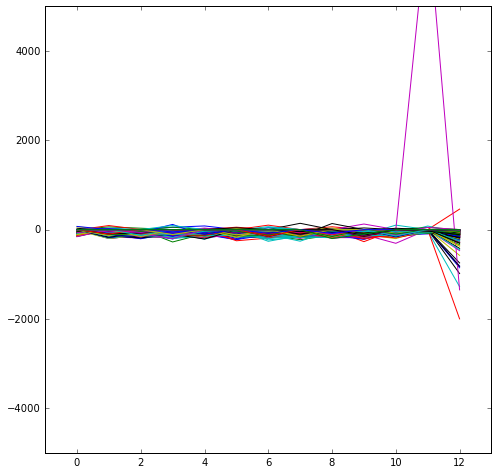

Iteracio: 2
-154.0 [ 0.]
[-26.12679907] [ 26.12679907]
[-51.20852617] [ 51.20852617]
31.0
Iteracio: 5
-108.0 [-3.125]
[-31.58083192] [ 25.33083192]
[-58.89843056] [ 52.64843056]
33.5410196625
Iteracio: 25
-160.0 [ 0.]
[-56.55293412] [ 56.55293412]
[-110.84375087] [ 110.84375087]
61.0
Iteracio: 79
-155.0 [ 0.]
[-45.30849123] [ 45.30849123]
[-88.80464281] [ 88.80464281]
27.0
Iteracio: 89
-179.0 [-1.87500338]
[-31.40889237] [ 27.65888561]
[-59.7614258] [ 56.01141904]
36.4828726939
Iteracio: 99
-108.0 [ 0.]
[-33.40261023] [ 33.40261023]
[-65.46911605] [ 65.46911605]
9.0
Iteracio: 102
-281.0 [ 0.]
[-47.29283394] [ 47.29283394]
[-92.69395452] [ 92.69395452]
33.0
Iteracio: 106
-86.0 [ 0.]
[-29.15238782] [ 29.15238782]
[-57.13868013] [ 57.13868013]
26.4007575649
Iteracio: 121
-95.0 [ 0.]
[-46.30065839] [ 46.30065839]
[-90.74929044] [ 90.74929044]
30.0
Iteracio: 138
-115.0 [-8.5]
[-46.99270637] [ 29.99270637]
[-83.94570449] [ 66.94570449]
78.3964284901
Iteracio: 170
459.0 [ 12.5]
[-52.06728934]

Iteracio: 1625
-128.0 [-4.625]
[-48.97463426] [ 39.72463426]
[-91.55028314] [ 82.30028314]
35.1567916625
Iteracio: 1630
-113.0 [-4.125]
[-41.63497815] [ 33.38497815]
[-77.64455717] [ 69.39455717]
49.0204039151
La predicció de compte en negatiu en predicció i real correctes és de: 0.639951426837
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.947783849423
La predicció de compte esta compresa en la zona determinada: 0.904068002429
La predicció de compte ens permet assegurar el signe final: 0.948391013965
Comptes signe 0.945355191257
The Mean Absolute Scaled error is [ 0.55942487]
The MAE error is [ 20.66721564]
The RMSE is [ 94.2145631]


array([ 0.55942487])

In [82]:
#Llegim les comptes del 3er cluster
accountcluster3=np.zeros((len(assignmentsclus[2]),13))
for i in np.arange(len(assignmentsclus[2])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster3[i]=accountclean[assignmentsclus[2][i].astype(int)]
print accountcluster3.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster3.shape[0]):
        plt.plot(accountcluster3[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=15.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#k2=    10.0* ExpSineSquared(length_scale=2.0, periodicity=3)+0.001  # seasonal component
# medium term irregularity
k2= 7.5*DotProduct(sigma_0=5.0)
k3 = 1.5**2* RationalQuadratic(length_scale=0.8, alpha=0.5)
k4 = 1.5**2 * RBF(length_scale=0.8) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp3 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-8,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster3,accountcluster3.shape[0],gp3,2)

(1139, 13)


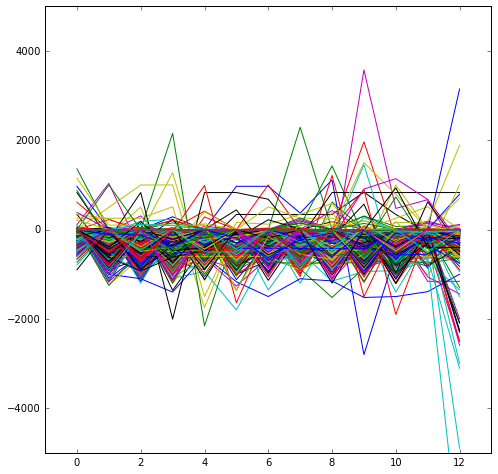

Iteracio: 31
-600.0 [-106.25]
[-315.87765242] [ 103.37765242]
[-517.12019874] [ 304.62019874]
595.650065055
Iteracio: 56
3150.0 [-74.875]
[-408.02879787] [ 258.27879787]
[-727.85644382] [ 578.10644382]
695.04604164
Iteracio: 77
-825.0 [-83.37500028]
[-409.26088679] [ 242.51088622]
[-722.11133783] [ 555.36133727]
610.953353375
Iteracio: 93
-2500.0 [-198.75]
[-831.20553203] [ 433.70553203]
[-1438.36284279] [ 1040.86284279]
2072.83260299
Iteracio: 96
701.0 [ 24.25000321]
[-161.63369931] [ 210.13370572]
[-340.08205373] [ 388.58206014]
195.760057213
Iteracio: 100
-590.0 [-38.75]
[-229.48627085] [ 151.98627085]
[-412.59309087] [ 335.09309087]
383.264921432
Iteracio: 105
-478.0 [-14.24997208]
[-152.087635] [ 123.58769084]
[-284.41179141] [ 255.91184724]
106.235587258
Iteracio: 106
-710.0 [-92.62501193]
[-394.14129013] [ 208.89126627]
[-683.5969172] [ 498.34689333]
682.236029538
Iteracio: 138
-528.0 [-120.12499999]
[-278.98593135] [ 38.73593136]
[-431.49242544] [ 191.24242546]
574.080133779
It

array([ 0.51154733])

In [83]:
#Llegim les comptes del 4rt cluster
accountcluster4=np.zeros((len(assignmentsclus[3]),13))
for i in np.arange(len(assignmentsclus[3])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster4[i]=accountclean[assignmentsclus[3][i].astype(int)]
print accountcluster4.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster4.shape[0]):
        plt.plot(accountcluster4[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 435.0**2 * RBF(length_scale=56.0)  # long term smooth rising trend
k2 = 24.0**2 * RBF(length_scale=1.1)+ 14.5*ExpSineSquared(length_scale=5.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 4.5**2* RationalQuadratic(length_scale=1.1, alpha=0.8)
k4 = 0.5**2 * RBF(length_scale=10.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp4 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster4,accountcluster4.shape[0],gp4,3)

In [48]:
print accountcluster4[1084]
accountcluster4[0]

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  -800.  -300. -2080.]


array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
           0.,     0., -1200.,     0.,  -500.])

(128, 13)


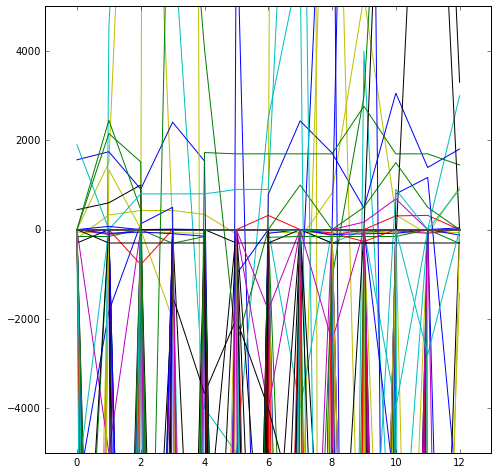

Iteracio: 4
0.0 [-7067.75]
[-7700.20553203] [-6435.29446797]
[-8307.36284279] [-5828.13715721]
59047.6581839
Iteracio: 5
0.0 [-18687.5]
[-19319.95553203] [-18055.04446797]
[-19927.11284279] [-17447.88715721]
191509.112055
Iteracio: 13
0.0 [-5862.49999488]
[-6494.95552691] [-5230.04446284]
[-7102.11283766] [-4622.88715209]
51080.5246645
Iteracio: 14
0.0 [-20000.]
[-20632.45553203] [-19367.54446797]
[-21239.61284279] [-18760.38715721]
334717.79158
Iteracio: 15
0.0 [-9750.]
[-10382.45553203] [-9117.54446797]
[-10989.61284279] [-8510.38715721]
116910.221965
Iteracio: 25
0.0 [-5261.25]
[-5893.70553203] [-4628.79446797]
[-6500.86284279] [-4021.63715721]
42826.8163655
Iteracio: 33
0.0 [-8750.00002731]
[-9382.45555934] [-8117.54449528]
[-9989.61287009] [-7510.38718452]
59160.797831
Iteracio: 36
0.0 [-1625.]
[-2257.45553203] [-992.54446797]
[-2864.61284279] [-385.38715721]
46840.1537145
Iteracio: 42
-6517.0 [-7871.125]
[-8503.58053203] [-7238.66946797]
[-9110.73784279] [-6631.51215721]
110911.0

array([ 0.18834431])

In [95]:
#Llegim les comptes del 5è cluster
accountcluster5=np.zeros((len(assignmentsclus[4]),13))
for i in np.arange(len(assignmentsclus[4])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster5[i]=accountclean[assignmentsclus[4][i].astype(int)]
print accountcluster5.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster5.shape[0]):
        plt.plot(accountcluster5[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 14450.0**2 * RBF(length_scale=1080.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
#k2= 100*ExpSineSquared(length_scale=20.0, periodicity=4.0)
k3 = 2.5**2* RationalQuadratic(length_scale=1.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp5 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster5,accountcluster5.shape[0],gp5,4)

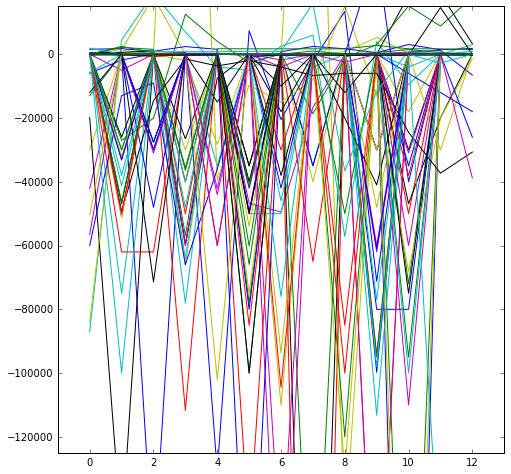

In [94]:
plt.figure(figsize=(8,8))
for k in np.arange(accountcluster5.shape[0]):
        plt.plot(accountcluster5[k])
plt.ylim(-125000,15000)
plt.xlim(-1,13)
plt.show()

(1561, 13)


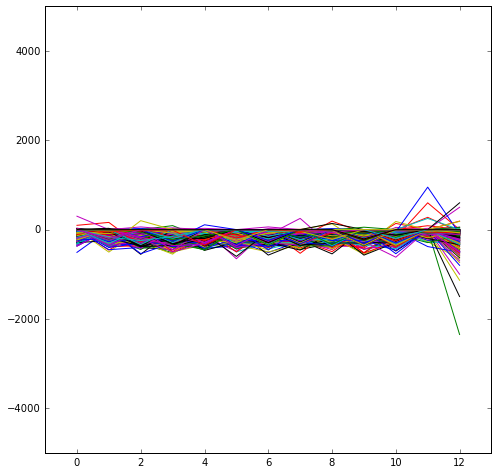

Iteracio: 47
-1135.0 [-24.75000299]
[-129.71520313] [ 80.21519715]
[-230.48179527] [ 180.98178928]
193.935556307
Iteracio: 52
-439.0 [ 0.]
[-62.83678694] [ 62.83678694]
[-123.16010241] [ 123.16010241]
46.2385120868
Iteracio: 71
-491.0 [-26.37499999]
[-110.41136961] [ 57.66136963]
[-191.08628444] [ 138.33628446]
112.151683001
Iteracio: 86
190.0 [ 0.]
[-66.14378772] [ 66.14378772]
[-129.64182394] [ 129.64182394]
37.1214223865
Iteracio: 162
-342.0 [-24.625]
[-139.43467786] [ 90.18467786]
[-249.65196861] [ 200.40196861]
168.718700801
Iteracio: 178
-257.0 [-22.62499006]
[-116.25651013] [ 71.00653002]
[-206.1427694] [ 160.89278928]
160.552172206
Iteracio: 183
-446.0 [-111.]
[-268.59675137] [ 46.59675137]
[-419.88963268] [ 197.88963268]
386.903088641
Iteracio: 191
-504.0 [-9.87499989]
[-69.98271674] [ 50.23271696]
[-127.68612492] [ 107.93612514]
49.9299509313
Iteracio: 221
-497.0 [-11.5]
[-91.73187937] [ 68.73187937]
[-168.75448356] [ 145.75448356]
75.1664818919
Iteracio: 265
-168.0 [-6.375]


array([ 0.47112391])

In [86]:
#Llegim les comptes del 6è cluster
accountcluster6=np.zeros((len(assignmentsclus[5]),13))
for i in np.arange(len(assignmentsclus[5])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster6[i]=accountclean[assignmentsclus[5][i].astype(int)]
print accountcluster6.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster6.shape[0]):
        plt.plot(accountcluster6[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 105.0**2 * RBF(length_scale=23.5)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2 =  10.0**2 * RBF(length_scale=0.6) 
k3 = 10.5**2* RationalQuadratic(length_scale=1.5, alpha=0.9)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=9.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp6 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster6,accountcluster6.shape[0],gp6,5)

(407, 13)


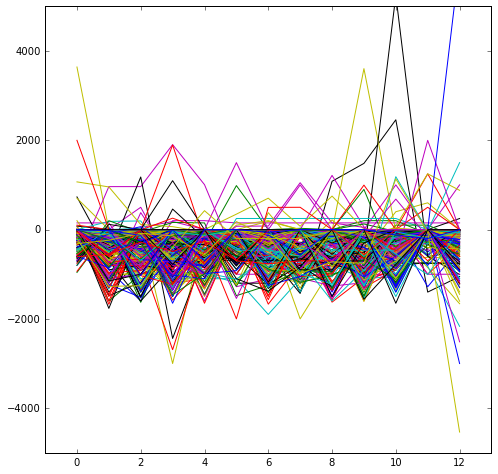

Iteracio: 5
-1450.0 [-270.]
[-702.10965947] [ 162.10965947]
[-1116.93493256] [ 576.93493256]
943.593132658
Iteracio: 55
-940.0 [-40.]
[-344.13809442] [ 264.13809442]
[-636.11066507] [ 556.11066507]
491.035640254
Iteracio: 68
-1660.0 [-202.5001407]
[-617.84489281] [ 212.84461142]
[-1016.57585484] [ 611.57557345]
1053.03893565
Iteracio: 71
-500.0 [-62.49999806]
[-280.08595658] [ 155.08596047]
[-488.96847677] [ 363.96848065]
571.241630136
Iteracio: 88
-1200.0 [-137.44320445]
[-581.85632115] [ 306.96991224]
[-1008.49291318] [ 733.60650427]
1090.09907807
Iteracio: 136
-2167.0 [-198.74999993]
[-596.69773491] [ 199.19773505]
[-978.72756049] [ 581.22756063]
895.206121516
Iteracio: 161
-3000.0 [-60.]
[-438.41742599] [ 318.41742598]
[-801.69815493] [ 681.69815493]
678.089227167
Iteracio: 173
-1283.0 [-299.875]
[-663.76804379] [ 64.01804379]
[-1013.10536583] [ 413.35536583]
873.443186475
Iteracio: 268
-892.0 [-111.24995342]
[-422.93178968] [ 200.43188284]
[-722.14635248] [ 499.64644564]
805.50729

array([ 0.61077328])

In [88]:
#Llegim les comptes del 7è cluster
accountcluster7=np.zeros((len(assignmentsclus[6]),13))
for i in np.arange(len(assignmentsclus[6])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster7[i]=accountclean[assignmentsclus[6][i].astype(int)]
print accountcluster7.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster7.shape[0]):
        plt.plot(accountcluster7[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1150.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2 = 3.0**2 * RBF(length_scale=1.1) + 40*ExpSineSquared(length_scale=2.0, periodicity=3.0) 
k3 = 10.5**2* RationalQuadratic(length_scale=1., alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=5.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp7 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster7,accountcluster7.shape[0],gp7,6)

(2666, 13)


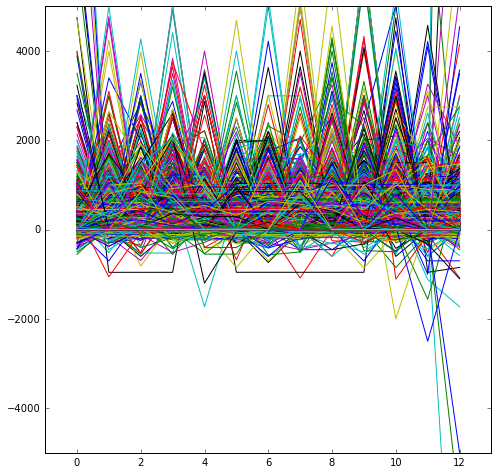

Iteracio: 40
160.0 [ 6.375]
[-59.76878169] [ 72.51878169]
[-123.26681212] [ 136.01681212]
71.4212853427
Iteracio: 54
1300.0 [ 262.50000507]
[ 108.24757712] [ 416.75243302]
[-39.83475371] [ 564.83476385]
637.102817448
Iteracio: 63
300.0 [ 12.5]
[-35.39313968] [ 60.39313968]
[-81.37055378] [ 106.37055378]
94.3398113206
Iteracio: 121
1233.0 [ 0.]
[-395.59272518] [ 395.59272518]
[-775.36174136] [ 775.36174136]
1574.06162522
Iteracio: 130
1250.0 [ 613.75]
[ 368.13851427] [ 859.36148573]
[ 132.35148797] [ 1095.14851203]
2219.61708409
Iteracio: 165
1600.0 [ 0.]
[-529.14855463] [ 529.14855463]
[-1037.13116707] [ 1037.13116707]
1400.89257261
Iteracio: 169
1000.0 [ 165.12499632]
[-139.21937255] [ 469.46936519]
[-431.38996666] [ 761.6399593]
891.209851831
Iteracio: 173
830.0 [ 446.125]
[ 289.85139614] [ 602.39860386]
[ 139.82873644] [ 752.42126356]
1315.31289053
Iteracio: 175
3495.0 [ 143.125]
[-489.33053203] [ 775.58053203]
[-1096.48784279] [ 1382.73784279]
2026.13548412
Iteracio: 241
2723.0 [ 0

Iteracio: 1222
576.0 [ 0.]
[-93.2627374] [ 93.2627374]
[-182.79496531] [ 182.79496531]
96.0416576283
Iteracio: 1236
475.0 [ 90.5]
[-89.28695631] [ 270.28695631]
[-261.88243437] [ 442.88243437]
449.885540999
Iteracio: 1278
1000.0 [ 502.5]
[ 279.69101299] [ 725.30898701]
[ 65.79438547] [ 939.20561453]
1444.54144973
Iteracio: 1279
2400.0 [ 428.75]
[ 136.85971656] [ 720.64028344]
[-143.35495553] [ 1000.85495553]
1454.95704404
Iteracio: 1281
853.0 [ 0.]
[-420.04635602] [ 420.04635602]
[-823.2908578] [ 823.2908578]
1411.26078384
Iteracio: 1292
2001.0 [ 0.]
[-632.45553203] [ 632.45553203]
[-1239.61284279] [ 1239.61284279]
1800.69431054
Iteracio: 1311
200.0 [ 0.]
[-43.80379064] [ 43.80379064]
[-85.85542965] [ 85.85542965]
99.4987437107
Iteracio: 1312
419.0 [ 0.]
[-107.15293197] [ 107.15293197]
[-210.01974667] [ 210.01974667]
133.701159307
Iteracio: 1314
2133.0 [ 124.49997073]
[-444.70918006] [ 693.70912152]
[-991.14996482] [ 1240.14990628]
2107.58866955
Iteracio: 1321
870.0 [ 415.]
[ 277.75155

Iteracio: 2616
1469.0 [ 65.125]
[-398.497197] [ 528.747197]
[-843.57450612] [ 973.82450612]
1415.77717173
Iteracio: 2620
0.0 [ 454.22487844]
[ 438.44306307] [ 470.0066938]
[ 423.29252032] [ 485.15723656]
1522.9724226
Iteracio: 2630
0.0 [ 450.]
[ 253.54708173] [ 646.45291827]
[ 64.9522802] [ 835.0477198]
1734.2145196
Iteracio: 2634
500.0 [ 0.]
[-134.25737514] [ 134.25737514]
[-263.14445528] [ 263.14445528]
540.83269132
Iteracio: 2643
5230.0 [ 496.87438692]
[-1.82176811] [ 995.57054194]
[-480.57007692] [ 1474.31885076]
2002.67945513
La predicció de compte en negatiu en predicció i real correctes és de: 0.665791447862
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.96624156039
La predicció de compte esta compresa en la zona determinada: 0.872843210803
La predicció de compte ens permet assegurar el signe final: 0.940735183796
Comptes signe 0.767441860465
The Mean Absolute Scaled error is [ 0.80550699]
The MAE error is [ 180.94202777]
The RMSE is [ 1359.30155016

array([ 0.80550699])

In [89]:
#Llegim les comptes del 8è cluster
accountcluster8=np.zeros((len(assignmentsclus[7]),13))
for i in np.arange(len(assignmentsclus[7])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster8[i]=accountclean[assignmentsclus[7][i].astype(int)]

print accountcluster8.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster8.shape[0]):
        plt.plot(accountcluster8[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1840.0**2 * RBF(length_scale=431.0)  # long term smooth rising trend
k2 = 68.0**2 * RBF(length_scale=10.0)*ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 10.0**2 * RBF(length_scale=0.4) 
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=8.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp8 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster8,accountcluster8.shape[0],gp8,7)

(2666, 13)


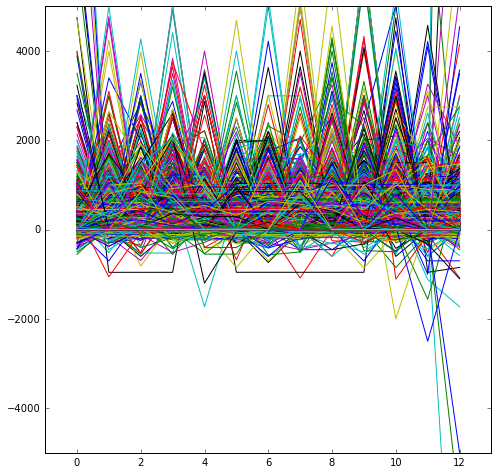

0
0.0 [ 63.00000295]
1
0.0 [ 249.08333334]
2
0.0 [ 333.33281307]
3
300.0 [ 129.16666793]
4
0.0 [ 66.66666282]
5
0.0 [ 20.33333265]
6
0.0 [ 87.49999409]
7
0.0 [-0.00020262]
8
0.0 [ 34.16666116]
9
0.0 [ 36.24999998]
10
0.0 [ 38.58333333]
11
0.0 [ 24.99999642]
12
300.0 [ 38.21485739]
13
0.0 [ 68.58333333]
14
0.0 [ 208.99993084]
15
0.0 [ 79.49999509]
16
611.0 [ 542.50000844]
17
0.0 [ 73.33333158]
18
0.0 [ 142.93279821]
19
840.0 [ 869.50327329]
20
0.0 [ 18.9166664]
21
0.0 [ 14.6672247]
22
0.0 [ 48.5833312]
23
-15.0 [ 25.66666446]
24
120.0 [ 176.24999891]
25
96.0 [ 18.58333333]
26
0.0 [ 50.83332127]
27
0.0 [ 270.09391321]
28
308.0 [ 558.99999993]
29
0.0 [ 83.33333124]
30
0.0 [ 18.41666667]
31
0.0 [ 29.33333333]
32
0.0 [ 17.62989551]
33
0.0 [ 139.58325833]
34
0.0 [ 387.61704105]
35
0.0 [ 20.83333358]
36
0.0 [ 64.74999616]
37
0.0 [ 309.833342]
38
278.0 [ 324.41666667]
39
0.0 [ 22.16666056]
40
160.0 [ 20.91666667]
41
0.0 [ 72.74999999]
42
0.0 [ 223.33270688]
43
0.0 [ 111.75]
44
0.0 [ 355.202402

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.44347808e-01,  -8.81692567e-03,   1.85631932e-02,
        -4.49379582e-11,  -3.11553123e-11,  -1.32604130e+05,
         2.65885108e+00,  -0.00000000e+00,   1.30131164e-01,
        -2.21304056e-06,   2.65885108e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


70
150.0 [ 187.49999389]
71
0.0 [ 40.99995883]
72
0.0 [ 9.16666288]
73
632.0 [ 737.5]
74
609.0 [ 710.66666382]
75
0.0 [ 13.75000001]
76
0.0 [ 27.66666626]
77
0.0 [ 104.99999974]
78
0.0 [ 20.99999597]
79
0.0 [ 145.33333117]
80
0.0 [ 29.16666381]
81
0.0 [ 130.83332598]
82
0.0 [ 263.83326134]
83
426.0 [ 315.91667596]
84
0.0 [ 49.74999784]
85
0.0 [ 46.2499953]
86
426.0 [ 426.]
87
0.0 [ 41.66666418]
88
0.0 [ 317.24999301]
89
0.0 [ 45.58333539]


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.33463528e+00,  -8.08020641e-33,   3.75000583e-01,
        -9.20813682e-07,  -5.65141681e-09,  -2.34144571e+07,
         1.33463528e+00,  -0.00000000e+00,   1.33463528e+00,
        -0.00000000e+00,   1.33463528e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


90
0.0 [ 41.66666418]
91
0.0 [ 41.66671511]
92
0.0 [ 83.33333009]
93
365.0 [ 426.08333333]
94
1000.0 [ 366.66666667]
95
0.0 [ 252.16666667]
96
372.0 [ 155.09039339]
97
565.0 [ 621.83333329]
98
0.0 [ 48.16666667]
99
0.0 [ 127.41666667]
100
0.0 [ 522.05178187]
101
-240.0 [ 64.5]
102
0.0 [ 12.49999322]
103
0.0 [ 99.24999718]
104
0.0 [ 63.99999193]
105
0.0 [ 526.41666662]
106
0.0 [ 537.49988837]
107
32.0 [ 76.66666827]
108
749.0 [ 205.33334681]
109
0.0 [ 19.17097345]
110
620.0 [ 606.2376174]
111
0.0 [ 16.66666195]
112
151.0 [ 73.91668202]
113
630.0 [ 459.25]
114
0.0 [ 162.08330809]
115
0.0 [ 185.24154988]
116
820.0 [ 491.50007928]
117
0.0 [ 33.33333031]
118
0.0 [ 21.41666667]
119
91.0 [ 115.74999997]
120
0.0 [ 237.49959919]
121
1233.0 [ 711.50495839]
122
0.0 [ 212.66666016]
123
0.0 [ 86.08333244]
124
0.0 [ 263.58321894]
125
0.0 [ 250.00000739]
126
0.0 [ 72.41666317]
127
0.0 [ 185.00000436]
128
-75.0 [-37.41667098]
129
0.0 [ 118.08332272]
130
1250.0 [ 636.66665663]
131
650.0 [ 595.83333655]

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.35204128e+000,  -3.48106363e-288,   3.96555659e-001,
        -3.30894567e-002,  -5.28134616e-009,  -2.17590299e+007,
         1.35204128e+000,  -8.13773178e-009,   1.35204128e+000,
        -0.00000000e+000,   1.35204128e+000]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


274
0.0 [ 34.41666344]
275
0.0 [ 166.66670213]
276
0.0 [ 395.83333333]
277
0.0 [ 145.41665908]
278
0.0 [ 12.16666667]
279
728.0 [ 606.66670069]
280
0.0 [ 233.24999777]
281
0.0 [ 111.16665987]
282
400.0 [ 158.33333331]
283
0.0 [ 170.33333328]
284
0.0 [ 22.08333083]
285
0.0 [ 12.24999692]
286
4.0 [ 188.85218527]
287
393.0 [ 458.58332991]
288
0.0 [ 23.58332956]
289
0.0 [ 394.5]
290
0.0 [ 293.14010656]
291
0.0 [ 16.16666665]
292
200.0 [ 157.95702259]
293
75.0 [ 179.16665591]
294
550.0 [ 358.33333333]
295
0.0 [ 524.9661195]
296
0.0 [ 33.08333043]
297
120.0 [ 165.54979278]
298
340.0 [ 125.66666225]
299
0.0 [ 241.66667156]
300
720.0 [ 660.]
301
0.0 [ 17.50000005]
302
1005.0 [ 710.03969312]
303
400.0 [ 28.08333209]
304
300.0 [ 232.41666667]
305
0.0 [ 25.91666668]
306
0.0 [ 833.33333333]
307
0.0 [ 250.99998796]
308
33.0 [ 80.5]
309
310.0 [ 129.16667684]
310
550.0 [ 308.33333333]
311
0.0 [ 72.74999521]
312
0.0 [ 15.16666266]
313
492.0 [ 451.00000249]
314
0.0 [ 124.99999999]
315
0.0 [ 22.65487837

621
0.0 [ 23.83332967]
622
0.0 [ 25.83333162]
623
350.0 [ 129.1666686]
624
550.0 [ 199.99998176]
625
365.0 [ 365.08333333]
626
0.0 [ 302.16268171]
627
0.0 [ 48.49998955]
628
50.0 [ 244.16634274]
629
627.0 [ 731.66666667]
630
1000.0 [ 763.]
631
0.0 [ 32.91667395]
632
0.0 [ 20.24999598]
633
0.0 [ 70.49999995]
634
230.0 [ 183.33333693]
635
0.0 [ 175.33333333]
636
0.0 [ 113.78870495]
637
426.0 [ 390.41666809]
638
628.0 [ 174.83854412]
639
0.0 [ 182.5]
640
363.0 [ 423.58332967]
641
300.0 [ 300.]
642
0.0 [ 26.83333333]
643
150.0 [ 166.66666667]
644
0.0 [ 42.83333333]
645
0.0 [ 10.08333333]
646
350.0 [ 47.51179258]
647
0.0 [ 133.33333333]
648
0.0 [ 168.2977023]
649
0.0 [ 71.66666491]
650
0.0 [ 181.41666667]
651
0.0 [ 49.16666463]
652
0.0 [ 166.74999516]
653
0.0 [ 38.49999457]
654
0.0 [ 16.83333333]
655
0.0 [ 16.66666667]
656
0.0 [ 41.66666389]
657
15000.0 [ 125.91666667]
658
0.0 [ 166.6588115]
659
1336.0 [ 792.40284598]
660
0.0 [ 87.49999629]
661
0.0 [ 12.91666171]
662
754.0 [ 377.]
663
0.0 [

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.31361784e-01,  -0.00000000e+00,   4.30214159e-01,
        -2.87034967e-03,  -2.53235004e-08,  -8.65674764e+07,
         4.27375405e-10,  -1.52602551e-17,   3.33006588e-08,
        -2.29857318e-15,   8.31361784e-01]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


793
0.0 [ 297.49983055]
794
0.0 [ 326.94896382]
795
571.0 [ 666.16666386]
796
0.0 [ 16.66666666]
797
0.0 [ 15.66665471]
798
50.0 [ 550.000239]
799
300.0 [ 338.91666364]
800
600.0 [ 301.75]
801
255.0 [ 298.58333932]
802
0.0 [ 31.82223332]
803
120.0 [ 257.91666238]
804
0.0 [ 50.25]
805
600.0 [ 700.08333333]
806
0.0 [ 25.08332976]
807
520.0 [ 166.66665444]
808
0.0 [ 416.66666667]
809
0.0 [ 17.08333403]
810
-75.0 [ 213.75]
811
0.0 [-4.75]
812
632.0 [ 737.49999724]
813
0.0 [ 108.33333333]
814
750.0 [ 465.93284437]
815
0.0 [ 149.74960599]
816
426.0 [ 388.]
817
0.0 [ 24.99999597]
818
0.0 [ 71.14413508]
819
0.0 [ 432.24999963]
820
0.0 [ 199.99999999]
821
0.0 [ 208.24993725]
822
0.0 [ 9.74999917]
823
0.0 [ 58.33332988]
824
16.0 [ 46.08333333]
825
0.0 [ 150.24998817]
826
400.0 [ 230.12019197]
827
0.0 [ 15.41666472]
828
0.0 [ 49.99999793]
829
860.0 [ 622.5000038]
830
0.0 [ 104.71108336]
831
0.0 [ 15.]
832
0.0 [ 78.5]
833
1151.0 [ 755.28516194]
834
1173.0 [ 455.24999999]
835
0.0 [ 13.33332823]
836

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.12051746e-01,  -1.61002372e-11,  -1.47077317e-01,
        -3.58973232e+00,   3.38795780e+00,   2.95701863e+01,
         1.12447285e-08,  -2.42092746e-15,   6.97291535e-02,
        -0.00000000e+00,   1.11870066e-02]), 'nit': 36, 'funcalls': 92}
  " state: %s" % convergence_dict)


1005
0.0 [-8.4067762]
1006
0.0 [ 76.54955362]
1007
0.0 [-0.00012947]
1008
0.0 [ 52.74999794]
1009
803.0 [ 788.16666667]
1010
0.0 [ 81.5]
1011
325.0 [ 22.58333332]
1012
0.0 [ 16.66666659]
1013
180.0 [ 503.97010398]
1014
340.0 [ 329.58333369]
1015
0.0 [ 499.41664218]
1016
0.0 [ 45.83333097]
1017
0.0 [ 69.41665941]
1018
0.0 [ 45.83333333]
1019
550.0 [ 242.91666681]
1020
0.0 [ 217.49722694]
1021
914.0 [ 781.45491437]
1022
0.0 [ 176.99997422]
1023
180.0 [ 514.95422612]
1024
0.0 [ 90.8333233]
1025
0.0 [ 74.99999999]
1026
0.0 [ 210.33336439]
1027
0.0 [ 211.75]
1028
0.0 [ 316.66650782]
1029
0.0 [ 26.99999862]
1030
0.0 [ 9.99999647]
1031
420.0 [ 579.66669017]
1032
632.0 [ 737.5]
1033
0.0 [ 237.83323584]
1034
0.0 [ 29.33333333]
1035
367.0 [ 428.2499967]
1036
350.0 [ 135.83333333]
1037
0.0 [ 10.41666219]
1038
0.0 [ 30.00000004]
1039
385.0 [ 288.5]
1040
0.0 [ 10.]
1041
-438.0 [ 157.86357913]
1042
0.0 [ 58.33333333]
1043
0.0 [ 141.66666669]
1044
427.0 [ 498.33333332]
1045
1280.0 [ 451.66667069]
104

1341
0.0 [ 506.33302115]
1342
0.0 [ 9.16666199]
1343
557.0 [ 477.66666707]
1344
0.0 [ 36.24999586]
1345
0.0 [ 29.9999917]
1346
0.0 [ 499.91666667]
1347
0.0 [ 185.49997729]
1348
180.0 [ 246.25]
1349
0.0 [ 431.33333333]
1350
0.0 [ 10.41666664]
1351
0.0 [ 12.49999403]
1352
-350.0 [ 308.08278942]
1353
0.0 [ 74.]
1354
0.0 [ 11.66665174]
1355
0.0 [ 236.66666667]
1356
1000.0 [ 84.5]
1357
0.0 [ 307.86239136]
1358
0.0 [ 18.99999515]
1359
740.0 [ 337.75938608]
1360
0.0 [ 254.58323838]
1361
0.0 [ 18.74868682]
1362
106.0 [ 319.83333333]
1363
0.0 [ 15.91666203]
1364
0.0 [ 250.]
1365
0.0 [ 261.66591588]
1366
0.0 [ 11.83329523]
1367
0.0 [ 16.66666527]
1368
200.0 [ 191.66666765]
1369
0.0 [ 9.99999377]
1370
0.0 [ 132.6666644]
1371
0.0 [ 9.33333329]
1372
0.0 [ 83.33330386]
1373
0.0 [ 141.6548512]
1374
280.0 [ 464.75]
1375
0.0 [ 249.99983146]
1376
700.0 [ 341.91666667]
1377
0.0 [ 392.83300524]
1378
0.0 [ 325.19374311]
1379
0.0 [ 12.49999322]
1380
0.0 [ 86.08333158]
1381
0.0 [ 41.66666389]
1382
0.0 [ 70.6

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.99771000e+00,  -0.00000000e+00,   4.14093055e-01,
        -3.87166652e-01,  -6.70587128e-09,  -2.39226252e+07,
         1.68349381e-01,  -3.09814235e-09,   1.68351425e-01,
        -4.09042052e-06,   1.99771000e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


1409
0.0 [ 173.91663298]
1410
645.0 [ 380.25000297]
1411
292.0 [ 307.7155968]
1412
0.0 [ 12.49999322]
1413
0.0 [ 243.91666667]
1414
0.0 [ 172.33332677]
1415
0.0 [ 10.33333107]
1416
0.0 [ 10.08332524]
1417
0.0 [ 62.33333333]
1418
0.0 [ 150.]
1419
0.0 [ 16.66666412]
1420
0.0 [ 21.91666252]
1421
800.0 [ 353.75]
1422
0.0 [ 39.66666667]
1423
0.0 [ 58.66666667]
1424
0.0 [ 65.2499905]
1425
0.0 [ 28.33335929]
1426
0.0 [ 110.91666423]
1427
0.0 [ 83.33333333]
1428
223.0 [ 48.16666485]
1429
600.0 [ 700.08333333]
1430
404.0 [ 471.4166633]
1431
50.0 [ 175.01653195]
1432
600.0 [ 803.74999122]
1433
600.0 [ 700.08333045]
1434
0.0 [ 295.83329057]
1435
0.0 [ 393.75]
1436
550.0 [ 557.17438987]
1437
0.0 [ 436.66666557]
1438
0.0 [ 183.33333104]
1439
0.0 [ 300.]
1440
-200.0 [ 25.99999766]
1441
0.0 [ 16.6666622]
1442
620.0 [ 277.33336125]
1443
0.0 [ 21.16666667]
1444
404.0 [ 471.4166633]
1445
-310.0 [ 9.91666667]
1446
200.0 [ 16.66666412]
1447
0.0 [ 24.99999642]
1448
426.0 [ 426.]
1449
900.0 [ 326.66666372]


1745
0.0 [ 249.75]
1746
0.0 [ 212.50000002]
1747
0.0 [ 20.83333333]
1748
543.0 [ 644.83332592]
1749
152.0 [ 12.66665945]
1750
0.0 [ 24.08333109]
1751
0.0 [ 30.08333333]
1752
0.0 [ 164.1666635]
1753
150.0 [ 120.8333338]
1754
1100.0 [ 631.25]
1755
0.0 [ 45.83333333]
1756
0.0 [ 770.9402088]
1757
0.0 [ 25.]
1758
646.0 [ 616.59532686]
1759
0.0 [ 356.24992159]
1760
530.0 [ 241.83337495]
1761
0.0 [ 65.00000372]
1762
1331.0 [ 233.33332645]
1763
42.0 [ 78.24999707]
1764
0.0 [ 78.66666717]
1765
426.0 [ 426.]
1766
0.0 [ 184.58464477]
1767
450.0 [ 81.66666818]
1768
0.0 [ 291.9999767]
1769
0.0 [ 71.33333333]
1770
0.0 [ 83.33333333]
1771
0.0 [-7.5000069]
1772
0.0 [ 68.91666667]
1773
0.0 [ 119.5832088]
1774
0.0 [ 177.66664842]
1775
0.0 [ 50.99999991]
1776
0.0 [ 73.66666461]
1777
1061.0 [ 661.36935848]
1778
0.0 [ 635.54431765]
1779
0.0 [ 109.5]
1780
0.0 [ 23.33333234]
1781
0.0 [ 169.1666665]
1782
171.0 [ 25.41666666]
1783
-280.0 [ 209.24999987]
1784
0.0 [ 34.]
1785
2000.0 [ 416.66666665]
1786
0.0 [ 55

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  8.92896005e-07,  -7.56268053e-13,   4.00019325e-01,
        -3.33465049e-05,  -9.10747982e-09,  -3.51928569e+07,
         1.23937960e+00,  -0.00000000e+00,   1.23937960e+00,
        -0.00000000e+00,   1.23937960e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


1874
498.0 [ 662.66665813]
1875
0.0 [ 101.74999754]
1876
0.0 [ 16.5]
1877
0.0 [ 78.33333333]
1878
0.0 [ 258.33318095]
1879
0.0 [ 272.62329231]
1880
690.0 [ 187.99999306]
1881
0.0 [ 630.315349]
1882
0.0 [ 67.08333144]
1883
20.0 [ 67.08333144]
1884
0.0 [ 2445.44102625]
1885
0.0 [ 46.08333121]
1886
0.0 [ 275.74999863]
1887
0.0 [ 15.833328]
1888
-70.0 [ 337.58353084]
1889
0.0 [ 174.66666667]
1890
0.0 [ 12.91666629]
1891
0.0 [ 249.66662899]
1892
100.0 [ 100.]
1893
0.0 [ 40.00002202]
1894
0.0 [ 163.99999764]
1895
0.0 [ 29.16665608]
1896
0.0 [ 18.33332865]
1897
0.0 [ 1.54804348]
1898
270.0 [ 151.24999138]
1899
0.0 [ 38.75000003]
1900
0.0 [ 13.33332919]
1901
0.0 [ 31.25]
1902
426.0 [ 176.25002912]
1903
165.0 [ 165.]
1904
330.0 [ 161.41666763]
1905
100.0 [ 146.66666667]
1906
420.0 [ 302.50000281]
1907
0.0 [ 77.24999874]
1908
0.0 [ 11.7500001]
1909
0.0 [ 42.24999763]
1910
-110.0 [-3.83333333]
1911
1000.0 [ 183.33331669]
1912
0.0 [ 277.08333333]
1913
0.0 [ 177.49517698]
1914
0.0 [ 12.49999356]
19

2210
0.0 [ 13.16666495]
2211
44.0 [ 53.24999485]
2212
0.0 [ 99.99999609]
2213
0.0 [ 77.83332929]
2214
0.0 [ 24.99999658]
2215
0.0 [ 17.99999498]
2216
0.0 [ 488.14985145]
2217
0.0 [ 82.66666663]
2218
0.0 [ 171.]
2219
0.0 [ 84.33333332]
2220
0.0 [ 103.58333333]
2221
0.0 [ 70.74999582]
2222
0.0 [ 268.75]
2223
0.0 [ 246.33333331]
2224
0.0 [ 6.93041032]
2225
100.0 [ 103.61166794]
2226
0.0 [ 52.58333333]
2227
0.0 [ 68.74999698]
2228
193.0 [ 498.25000103]
2229
0.0 [ 349.99998816]
2230
0.0 [ 20.58332968]
2231
0.0 [ 68.24999822]
2232
0.0 [ 87.49999998]
2233
0.0 [ 27.66666667]
2234
0.0 [ 473.25]
2235
240.0 [ 245.25]
2236
0.0 [ 92.5]
2237
0.0 [ 12.33333595]
2238
0.0 [ 21.75003344]
2239
0.0 [ 309.59660774]
2240
0.0 [ 143.41870549]
2241
150.0 [ 270.41665887]
2242
568.0 [ 672.58332002]
2243
0.0 [ 166.66651962]
2244
0.0 [ 405.99999891]
2245
0.0 [ 195.24511945]
2246
375.0 [ 406.25000079]
2247
632.0 [ 737.49999724]
2248
75.0 [ 79.5833324]
2249
854.0 [ 808.5]
2250
0.0 [ 450.]
2251
0.0 [ 86.24999556]
225

2548
0.0 [ 179.33333336]
2549
54.0 [ 282.08333226]
2550
0.0 [ 108.16666667]
2551
0.0 [ 14.58332714]
2552
500.0 [ 205.83333517]
2553
0.0 [ 365.08333332]
2554
0.0 [ 28.20871418]
2555
200.0 [ 24.99999999]
2556
589.0 [ 687.33333044]
2557
94.0 [ 109.83333333]
2558
0.0 [ 49.99999707]
2559
0.0 [ 15.66666667]
2560
0.0 [ 493.91666667]
2561
0.0 [ 35.58332695]
2562
9.0 [ 261.00000002]
2563
0.0 [ 61.74999794]
2564
0.0 [-21.12902156]
2565
0.0 [ 10.91666667]
2566
0.0 [ 41.]
2567
268.0 [ 208.6667017]
2568
0.0 [ 189.66664947]
2569
0.0 [ 23.74999287]
2570
310.0 [ 174.91666363]
2571
0.0 [ 54.16666378]
2572
-50.0 [-1.16666986]
2573
0.0 [ 107.]
2574
152.0 [ 96.66666667]
2575
0.0 [ 72.74999521]
2576
1000.0 [ 190.166663]
2577
-100.0 [ 124.99999983]
2578
0.0 [ 18.83332876]
2579
0.0 [ 53.33333333]
2580
0.0 [ 244.99991198]
2581
0.0 [ 107.74999995]
2582
0.0 [ 24.08332972]
2583
875.0 [ 828.42164396]
2584
0.0 [ 317.50000007]
2585
0.0 [ 166.66666667]
2586
632.0 [ 745.]
2587
0.0 [ 20.83333333]
2588
0.0 [ 41.6666635

In [42]:
#Llegim les comptes del 8è cluster
accountcluster8=np.zeros((len(assignmentsclus[7]),13))
for i in np.arange(len(assignmentsclus[7])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster8[i]=accountclean[assignmentsclus[7][i].astype(int)]

print accountcluster8.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster8.shape[0]):
        plt.plot(accountcluster8[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 1840.0**2 * RBF(length_scale=431.0)  # long term smooth rising trend
k2 = 68.0**2 * RBF(length_scale=10.0)*ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 10.0**2 * RBF(length_scale=0.4) 
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=8.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp8 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster8,accountcluster8.shape[0],gp8,7)

(1066, 13)


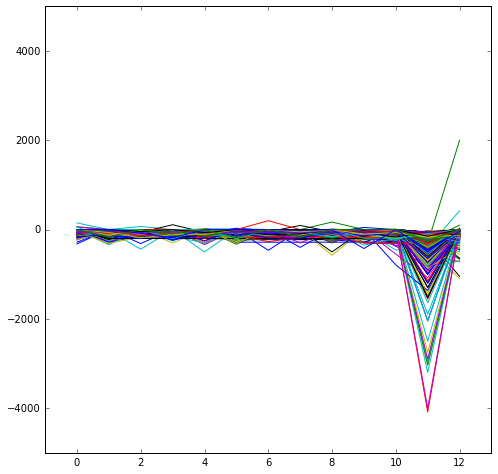

Iteracio: 0
0.0 [-98.11603171]
[-142.60602353] [-53.62603988]
[-185.31641568] [-10.91564773]
158.549676758
Iteracio: 10
-190.0 [-76.16844828]
[-120.26940619] [-32.06749037]
[-162.60632578] [ 10.26942922]
113.762911355
Iteracio: 12
-1100.0 [ 0.]
[-132.28756504] [ 132.28756504]
[-259.28362748] [ 259.28362748]
287.70297183
Iteracio: 22
-185.0 [-38.25]
[-109.94891723] [ 33.44891723]
[-178.77987777] [ 102.27987777]
146.352314638
Iteracio: 36
-308.0 [-47.375]
[-117.23451441] [ 22.48451441]
[-184.29964825] [ 89.54964825]
152.325309781
Iteracio: 38
-463.0 [-48.625]
[-105.62924849] [ 8.37924849]
[-160.35332705] [ 63.10332705]
146.041090108
Iteracio: 51
-720.0 [-43.75]
[-240.50117548] [ 153.00117548]
[-429.38230394] [ 341.88230394]
541.794241387
Iteracio: 52
-637.0 [-51.75]
[-86.37635381] [-17.12364619]
[-119.61765347] [ 16.11765347]
94.3980932011
Iteracio: 87
-179.0 [-9.375]
[-70.50204723] [ 51.75204723]
[-129.18401257] [ 110.43401257]
74.7997326198
Iteracio: 108
-340.0 [ 0.]
[-84.40502647] [ 8

array([ 0.79346057])

In [33]:
#Llegim les comptes del 9è cluster
accountcluster9=np.zeros((len(assignmentsclus[8]),13))
for i in np.arange(len(assignmentsclus[8])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster9[i]=accountclean[assignmentsclus[8][i].astype(int)]

print accountcluster9.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster9.shape[0]):
        plt.plot(accountcluster9[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2 = 3.0*ExpSineSquared(length_scale=2.0, periodicity=4.0)
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.8)
k4 = 0.9**2 * RBF(length_scale=0.5) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp9 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster9,accountcluster9.shape[0],gp9,8)

(1066, 13)


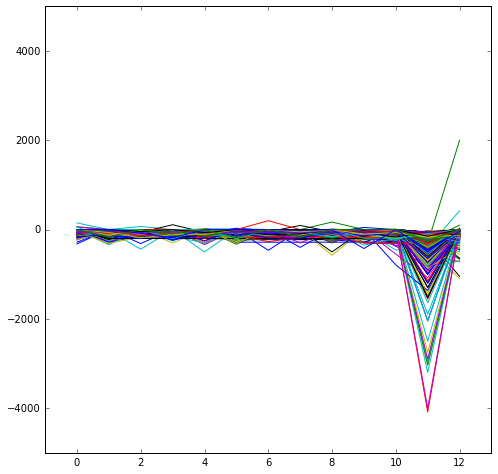

0
0.0 [-78.41666667]
1
0.0 [-40.25]
2
-15.0 [-31.84733441]
3
-73.0 [-47.16666667]
4
-49.0 [-74.]
5
-72.0 [-59.83333333]
6
-54.0 [-74.41666667]
7
0.0 [-30.]
8
-51.0 [-54.88678526]
9
-70.0 [-60.91666667]
10
-190.0 [-49.41666667]
11
-191.0 [-49.5]
12
-1100.0 [-33.33333333]
13
-150.0 [-62.5]
14
0.0 [-46.08333333]
15
-73.0 [-42.66666667]
16
-35.0 [-45.53475207]
17
0.0 [-56.97291371]
18
0.0 [-93.66666667]
19
0.0 [-25.0000003]
20
0.0 [-22.83333333]
21
-180.0 [-121.24978732]
22
-185.0 [-116.44954816]
23
-70.0 [-58.75]
24
0.0 [-27.]
25
0.0 [-32.41666667]
26
0.0 [-36.08333333]
27
-33.0 [-78.16666669]
28
-60.0 [-60.]
29
-20.0 [-41.66666667]
30
-60.0 [-61.5]
31
-73.0 [-30.83333333]
32
0.0 [-75.]
33
-40.0 [-141.66686227]
34
0.0 [-29.66666667]
35
0.0 [-13.75]
36
-308.0 [-66.83333333]
37
-68.0 [-34.5]
38
-463.0 [-57.08333333]
39
-41.0 [-74.]
40
0.0 [-24.33533894]
41
-106.0 [-69.58333333]
42
0.0 [-33.33333333]
43
0.0 [-21.5]
44
-40.0 [-30.83333333]
45
-35.0 [-25.75]
46
-60.0 [-41.25]
47
-80.0 [-61.666

376
-121.0 [-53.50000003]
377
-9.0 [-75.]
378
-220.0 [-137.5]
379
0.0 [-24.66666667]
380
-135.0 [-72.25]
381
0.0 [-16.58333333]
382
0.0 [-47.]
383
0.0 [-20.66666667]
384
-132.0 [-146.01091356]
385
0.0 [-16.66666667]
386
-54.0 [-53.52589283]
387
-89.0 [-65.08333333]
388
-62.0 [-71.5]
389
0.0 [-42.33333333]
390
-64.0 [-40.75]
391
-108.0 [-48.16666667]
392
-60.0 [-60.]
393
-110.0 [-22.41728865]
394
-53.0 [-53.]
395
0.0 [-23.66666667]
396
-90.0 [-49.66666667]
397
-39.0 [-50.41666688]
398
-176.0 [-25.]
399
-272.0 [-72.15522737]
400
-62.0 [-48.91666667]
401
-39.0 [-25.33333333]
402
-439.0 [-115.75]
403
-41.0 [-85.9166667]
404
-51.0 [-51.]
405
0.0 [-34.66666667]
406
-47.0 [-47.42865451]
407
-36.0 [-44.65163391]
408
0.0 [-68.66666667]
409
420.0 [-38.08333333]
410
-71.0 [-70.2198396]
411
-104.0 [-24.25]
412
-65.0 [-51.25]
413
-52.0 [-35.16666667]
414
-50.0 [-50.40869708]
415
-55.0 [-60.58333333]
416
-19.0 [-89.5]
417
-80.0 [-80.66666651]
418
0.0 [-26.]
419
0.0 [-30.41666667]
420
0.0 [-9.5833333

747
0.0 [-12.91666667]
748
-110.0 [-61.50000001]
749
-40.0 [-77.19365864]
750
0.0 [-27.75]
751
-40.0 [-54.30222037]
752
-699.0 [-71.91666667]
753
0.0 [-9.16666667]
754
0.0 [-39.25]
755
0.0 [-21.08333333]
756
0.0 [-83.33333333]
757
-40.0 [-51.33333333]
758
-140.0 [-23.75]
759
-79.0 [-42.83333333]
760
-60.0 [-77.08333333]
761
-22.0 [-28.91666667]
762
0.0 [-8.5]
763
-59.0 [-56.91666667]
764
-62.0 [-61.75969066]
765
0.0 [-52.83333716]
766
-92.0 [-65.94226047]
767
-20.0 [-27.5]
768
0.0 [-10.33333333]
769
-57.0 [-56.52206098]
770
-86.0 [-54.41666667]
771
0.0 [-18.58333333]
772
0.0 [-86.08333333]
773
-85.0 [-73.33333333]
774
0.0 [-18.33333333]
775
-410.0 [-161.66666667]
776
0.0 [-12.66666667]
777
-72.0 [-30.08333333]
778
0.0 [-30.]
779
-150.0 [-12.5]
780
-100.0 [-79.83333333]
781
0.0 [-10.66666667]
782
-24.0 [-123.]
783
0.0 [-33.5]
784
-42.0 [-49.5]
785
-20.0 [-78.2500015]
786
0.0 [-39.50000226]
787
-60.0 [-59.5]
788
0.0 [-34.00000038]
789
0.0 [-65.58333333]
790
-79.0 [-27.33333333]
791
-70.0

In [39]:
#Llegim les comptes del 9è cluster
accountcluster9=np.zeros((len(assignmentsclus[8]),13))
for i in np.arange(len(assignmentsclus[8])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster9[i]=accountclean[assignmentsclus[8][i].astype(int)]

print accountcluster9.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster9.shape[0]):
        plt.plot(accountcluster9[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2= 0.4*DotProduct(sigma_0=1.0)* ExpSineSquared(length_scale=2.0, periodicity=4.0) 
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp9 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster9,accountcluster9.shape[0],gp9,8)

(297, 13)


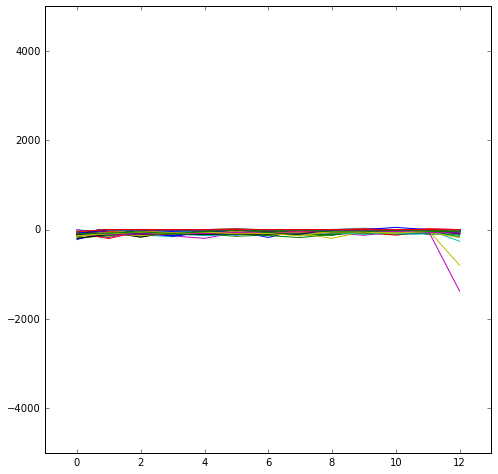

Iteracio: 10
-125.0 [-4.375]
[-25.97795161] [ 17.22795161]
[-46.71678516] [ 37.96678516]
36.1524549651
Iteracio: 22
-125.0 [ 0.]
[-15.87519541] [ 15.87519541]
[-31.115383] [ 31.115383]
32.0156211872
Iteracio: 77
-47.0 [ 0.]
[-21.16601096] [ 21.16601096]
[-41.48538148] [ 41.48538148]
17.0
Iteracio: 78
0.0 [-61.5]
[-83.77152517] [-39.22847484]
[-105.15218933] [-17.84781068]
58.3780780773
Iteracio: 110
-44.0 [ 0.]
[-19.51279736] [ 19.51279736]
[-38.24508283] [ 38.24508283]
21.5406592285
Iteracio: 150
-260.0 [ 0.]
[-33.07189279] [ 33.07189279]
[-64.82090987] [ 64.82090987]
22.4722050542
Iteracio: 157
-153.0 [-61.75]
[-97.25511281] [-26.24488719]
[-131.34002111] [ 7.84002111]
86.712167543
Iteracio: 200
-44.0 [-72.99999942]
[-84.99317243] [-61.00682642]
[-96.50661851] [-49.49338033]
145.712044801
Iteracio: 209
0.0 [-75.875]
[-113.62665566] [-38.12334434]
[-149.8682451] [-1.8817549]
27.0185121722
Iteracio: 229
-797.0 [ 0.]
[-53.13603268] [ 53.13603268]
[-104.14662405] [ 104.14662405]
86.40601

array([ 0.83510057])

In [96]:
#Llegim les comptes del 10è cluster
accountcluster10=np.zeros((len(assignmentsclus[9]),13))
for i in np.arange(len(assignmentsclus[9])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster10[i]=accountclean[assignmentsclus[9][i].astype(int)]

print accountcluster10.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster10.shape[0]):
        plt.plot(accountcluster10[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 30.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp10 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster10,accountcluster10.shape[0],gp10,9)

(297, 13)


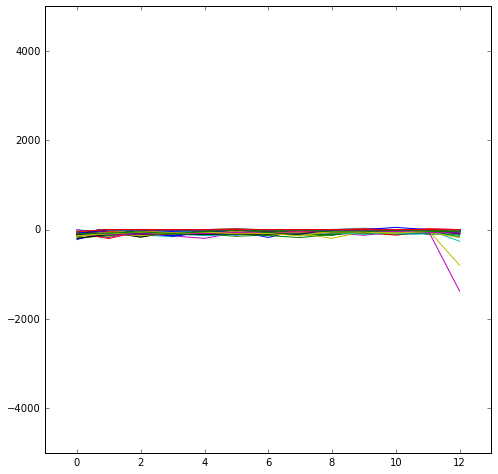

0
0.0 [-12.08333333]
1
0.0 [-7.33333333]
2
-77.0 [-69.91666667]
3
0.0 [-10.]
4
-50.0 [-91.33333333]
5
0.0 [-5.66666667]
6
0.0 [-12.33333333]
7
0.0 [-5.08333333]
8
0.0 [-6.33333333]
9
0.0 [-7.58333333]
10
-125.0 [-9.5]
11
0.0 [-6.16666667]
12
0.0 [-29.87292319]
13
-76.0 [-47.00690283]
14
0.0 [-6.25]
15
0.0 [-18.28762747]
16
-75.0 [-69.58333333]
17
0.0 [-5.]
18
0.0 [-7.33333333]
19
0.0 [-4.75]
20
0.0 [-10.41666667]
21
0.0 [-46.83333333]
22
-125.0 [-4.]
23
-54.0 [-32.07315496]
24
0.0 [-14.75]
25
0.0 [-4.5]
26
0.0 [-57.33333333]
27
0.0 [-4.25]
28
-38.0 [-15.5]
29
0.0 [-5.75]
30
0.0 [-9.08333333]
31
0.0 [-9.]
32
0.0 [-11.49999715]
33
0.0 [-12.33333333]
34
0.0 [-12.33333333]
35
0.0 [-5.5]
36
0.0 [-7.91666667]
37
0.0 [-10.08333333]
38
0.0 [-29.16666667]
39
0.0 [-9.91666667]
40
0.0 [-14.24999996]
41
0.0 [-9.58333333]
42
0.0 [-4.58333333]
43
0.0 [-5.5]
44
0.0 [-5.08333333]
45
-14.0 [-8.83333333]
46
0.0 [-11.16666667]
47
0.0 [-5.75]
48
0.0 [-4.5]
49
0.0 [-10.33333333]
50
-28.0 [-27.58333246]
51


In [40]:
#Llegim les comptes del 10è cluster
accountcluster10=np.zeros((len(assignmentsclus[9]),13))
for i in np.arange(len(assignmentsclus[9])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster10[i]=accountclean[assignmentsclus[9][i].astype(int)]

print accountcluster10.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster10.shape[0]):
        plt.plot(accountcluster10[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 30.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp10 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster10,accountcluster10.shape[0],gp10,9)

(1214, 13)


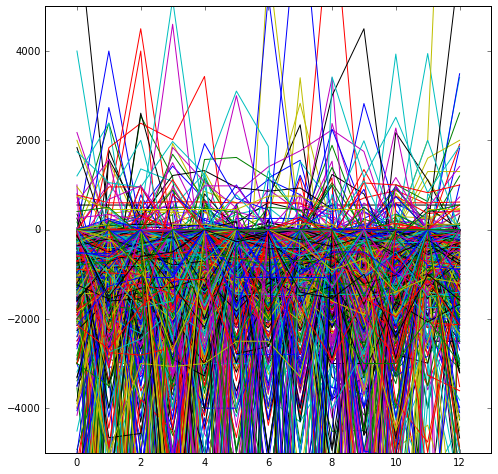

Iteracio: 0
-4200.0 [-3062.5]
[-3610.22302665] [-2514.77697335]
[-4136.03713223] [-1988.96286777]
8660.3378687
Iteracio: 2
-13485.0 [-500.]
[-947.2136172] [-52.78638281]
[-1376.5386897] [ 376.53868969]
6846.25970878
Iteracio: 3
-513.0 [ 655.75]
[ 108.02744099] [ 1203.47255901]
[-417.78621566] [ 1729.28621566]
5616.35112862
Iteracio: 15
-2965.0 [-1079.5]
[-1711.95553203] [-447.04446797]
[-2319.11284279] [ 160.11284279]
3289.16950004
Iteracio: 17
3409.0 [-734.99999999]
[-1282.72255762] [-187.27744235]
[-1808.53621295] [ 338.53621298]
14479.7250319
Iteracio: 27
-8700.0 [-2237.5]
[-2869.95553203] [-1605.04446797]
[-3477.11284279] [-997.88715721]
15952.5570364
Iteracio: 39
-30000.0 [ 0.]
[-547.72255863] [ 547.72255863]
[-1073.53621492] [ 1073.53621492]
23267.6677817
Iteracio: 51
0.0 [-3125.]
[-3757.45553203] [-2492.54446797]
[-4364.61284279] [-1885.38715721]
41984.215653
Iteracio: 58
-1715.0 [-3556.]
[-4103.72294157] [-3008.27705843]
[-4629.53696548] [-2482.46303452]
10478.890781
Iteracio: 

Iteracio: 661
-8001.0 [-4655.24999993]
[-5102.46424298] [-4208.03575688]
[-5531.78991631] [-3778.71008356]
15178.4165182
Iteracio: 664
-576.0 [-2449.93598786]
[-2997.65854537] [-1902.21343034]
[-3523.47220059] [-1376.39977513]
13958.0575296
Iteracio: 665
-14526.0 [-7655.24999987]
[-8287.7055319] [-7022.79446784]
[-8894.86284266] [-6415.63715708]
33839.6500721
Iteracio: 687
0.0 [-2252.4999999]
[-2800.22255814] [-1704.77744166]
[-3326.03621406] [-1178.96378575]
9599.44191086
Iteracio: 693
-4101.0 [-141.125]
[-688.84755753] [ 406.59755753]
[-1214.66121276] [ 932.41121276]
5134.95472229
Iteracio: 738
-6000.0 [-7103.375]
[-7651.09755911] [-6555.65244089]
[-8176.91121586] [-6029.83878414]
25376.1626335
Iteracio: 743
-4930.0 [-1848.125]
[-2480.58053203] [-1215.66946797]
[-3087.73784279] [-608.51215721]
7870.33086979
Iteracio: 747
-1830.0 [-368.74999997]
[-916.47259787] [ 178.97259794]
[-1442.28629186] [ 704.78629193]
2266.52729964
Iteracio: 755
312.0 [-1349.75]
[-1897.47257577] [-802.02742423

array([ 0.54119127])

In [34]:
#Llegim les comptes del 11è cluster
accountcluster11=np.zeros((len(assignmentsclus[10]),13))
for i in np.arange(len(assignmentsclus[10])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster11[i]=accountclean[assignmentsclus[10][i].astype(int)]

print accountcluster11.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster11.shape[0]):
        plt.plot(accountcluster11[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 2198.0**2 * RBF(length_scale=760.0)  # long term smooth rising trend
k2 = 550.0**2 * RBF(length_scale=56.0) \
    * ExpSineSquared(length_scale=21.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 35.5**2* RationalQuadratic(length_scale=2.0, alpha=0.8)
k4 = 0.9**2 * RBF(length_scale=0.8) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp11 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster11,accountcluster11.shape[0],gp11,10)

(1214, 13)


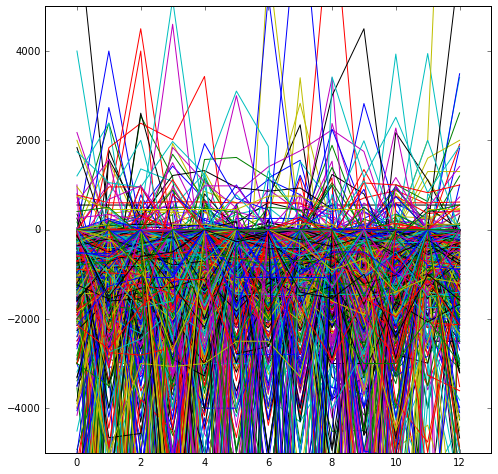

0
-4200.0 [-2625.]
1
-600.0 [-1055.]
2
-13485.0 [-1072.5]
3
-513.0 [-32.83333333]
4
0.0 [-1666.66666618]
5
0.0 [-499.99999996]
6
-1200.0 [-1125.]
7
0.0 [-541.66666667]
8
-1060.0 [-676.66666667]
9
0.0 [-1290.66666666]
10
-1500.0 [-1275.]
11
-1350.0 [-559.16666667]
12
0.0 [-200.]
13
-100.0 [-929.6666667]
14
0.0 [-500.]
15
-2965.0 [-1089.5]
16
0.0 [-416.66666667]
17
3409.0 [-2442.49999903]
18
0.0 [-641.66666667]
19
0.0 [-1791.33333333]
20
-1298.0 [-537.66666666]
21
0.0 [-418.91666667]
22
0.0 [-291.66666662]
23
-280.0 [-514.16666667]
24
0.0 [-350.]
25
0.0 [-710.83333333]
26
-300.0 [-611.33333333]
27
-8700.0 [-3691.66666667]
28
0.0 [-729.83333333]
29
-2900.0 [-2062.5]
30
0.0 [-172.58333334]
31
0.0 [-250.00000008]
32
0.0 [-569.16666667]
33
-310.0 [-483.33333334]
34
-1589.0 [-1307.16666653]
35
0.0 [-1125.00000018]
36
0.0 [-831.91666651]
37
-100.0 [-333.33333333]
38
-1200.0 [-777.5]
39
-30000.0 [-2083.33333333]
40
0.0 [-417.83330817]
41
0.0 [-666.66666667]
42
0.0 [-1000.]
43
0.0 [-459.66666667

341
0.0 [-500.]
342
0.0 [-1666.66666667]
343
0.0 [-583.33333333]
344
-1800.0 [-633.33333334]
345
0.0 [-2500.]
346
0.0 [-833.3333332]
347
-626.0 [-623.58333333]
348
-349.0 [-984.]
349
-1633.0 [-745.91666667]
350
0.0 [-1554.91666667]
351
0.0 [-833.33333333]
352
0.0 [-1839.83333305]
353
-1030.0 [-999.16666667]
354
0.0 [-291.66666667]
355
0.0 [-1499.99999993]
356
0.0 [-377.5]
357
-1841.0 [-558.41666661]
358
-884.0 [-141.66666667]
359
-1150.0 [-1173.33333332]
360
-1560.0 [-1702.41666667]
361
400.0 [ 108.16666643]
362
-980.0 [-1435.9166665]
363
0.0 [-249.99999989]
364
-100.0 [-384.7500001]
365
0.0 [-510.16666667]
366
-50.0 [-161.66666667]
367
0.0 [-750.]
368
0.0 [-156.33333333]
369
0.0 [-583.]
370
0.0 [-999.99999979]
371
-1349.0 [-1420.83333332]
372
0.0 [-199.99999996]
373
0.0 [-500.]
374
0.0 [-179.16666666]
375
0.0 [-257.33333333]
376
-250.0 [-1094.66666667]
377
0.0 [-141.66666667]
378
0.0 [-666.66666667]
379
0.0 [-3250.]
380
0.0 [-54.16666667]
381
-250.0 [-410.83333354]
382
0.0 [-212.91666

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.22280604e-01,  -2.92643432e-07,   2.23026869e-01,
        -1.49158422e-03,  -4.33764289e-09,  -2.19901853e+07,
         3.55832819e-01,  -0.00000000e+00,  -0.00000000e+00,
         3.55832819e-01,  -0.00000000e+00,   3.55832819e-01]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


414
139.0 [-322.16666667]
415
-1248.0 [-521.58332691]


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.13242969e+00,  -0.00000000e+00,   3.75000044e-01,
        -5.38856895e-08,  -2.09970674e-09,  -9.52144951e+06,
         1.13242969e+00,  -0.00000000e+00,  -0.00000000e+00,
         1.13242969e+00,  -0.00000000e+00,   1.13242969e+00]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


416
-1050.0 [-1002.5]
417
-600.0 [-434.16666667]
418
376.0 [-535.08333333]
419
0.0 [-362.58333333]
420
-850.0 [-1009.16666667]
421
0.0 [-749.99999982]
422
-1128.0 [-873.58333333]
423
-1010.0 [-1107.5]
424
0.0 [-2083.33333333]
425
0.0 [-1694.83332274]
426
0.0 [-3808.33333333]
427
-1330.0 [-808.33333333]
428
0.0 [-628.3333334]
429
-53.0 [-1168.]
430
0.0 [-182.25]
431
0.0 [-208.4999999]
432
0.0 [-208.33333332]
433
-1200.0 [-1250.]
434
-2700.0 [-1125.]
435
-3110.0 [-2773.74999997]
436
0.0 [-388.58333333]
437
-948.0 [-1064.58333333]
438
0.0 [-866.16666667]
439
-5800.0 [-1554.25]
440
-1800.0 [-1329.16666667]
441
0.0 [-402.66666667]
442
-20.0 [-480.83333333]
443
-200.0 [-791.66666667]
444
-2500.0 [-1216.66666667]
445
-700.0 [-229.16666667]
446
0.0 [  4.07396778e-08]
447
-1950.0 [-2125.83333333]
448
-1580.0 [-658.33333333]
449
0.0 [-583.33333333]
450
-40.0 [-1044.16666667]
451
0.0 [-650.]
452
110.0 [-422.16666667]
453
0.0 [-489.83333333]
454
-1050.0 [-1567.5]
455
0.0 [-1082.41666667]
456
0.0 [

754
-1828.0 [-759.41666667]
755
312.0 [-1185.33333333]
756
-60.0 [-512.5]
757
0.0 [-166.66666667]
758
0.0 [-238.33333333]
759
0.0 [-254.16666667]
760
-1200.0 [-546.25]
761
0.0 [-1792.08333333]
762
0.0 [-877.83333333]
763
0.0 [-249.99999991]
764
-27.0 [-323.58333333]
765
0.0 [-416.66666667]
766
0.0 [-423.25]
767
0.0 [-208.33333347]
768
0.0 [-500.0000001]
769
-1100.0 [-783.33333327]
770
0.0 [-349.99999982]
771
0.0 [-749.99999965]
772
-1400.0 [-1729.16666667]
773
0.0 [-551.66666667]
774
-2060.0 [-760.83333333]
775
-120.0 [-496.25]
776
-3000.0 [-916.66666667]
777
0.0 [-141.83333333]
778
0.0 [-596.83333333]
779
424.0 [ 305.41666667]
780
-1720.0 [-532.91666667]
781
-1523.0 [-1519.75]
782
0.0 [-583.33333357]
783
-1000.0 [-1383.33333325]
784
0.0 [-421.33333333]
785
0.0 [-807.75]
786
0.0 [-1834.5]
787
0.0 [-3750.]
788
0.0 [-833.58333333]
789
0.0 [-5000.]
790
-217.0 [ 209.75]
791
0.0 [-372.58333328]
792
0.0 [-256.]
793
-1141.0 [-475.41666667]
794
0.0 [-348.08333333]
795
-881.0 [-1216.25]
796
-25

1089
-290.0 [-431.66664212]
1090
-1334.0 [-389.08333338]
1091
0.0 [-1401.58333294]
1092
-1448.0 [-603.66666666]
1093
-40.0 [-1541.66666667]
1094
-5000.0 [-759.1666666]
1095
0.0 [-339.91666667]
1096
0.0 [-368.83333333]
1097
0.0 [-273.]
1098
-2150.0 [-1553.16666667]
1099
0.0 [-290.74999987]
1100
0.0 [-333.33333333]
1101
-450.0 [-475.]
1102
0.0 [-208.33333333]
1103
0.0 [-666.66666667]
1104
-850.0 [-1134.16666667]
1105
0.0 [-962.08332721]
1106
0.0 [-1250.]
1107
0.0 [-2250.00000003]
1108
0.0 [-498.91666667]
1109
-1520.0 [-893.33333333]
1110
0.0 [-165.25]
1111
-780.0 [-810.]
1112
0.0 [-750.00000025]
1113
-600.0 [-758.33333333]
1114
0.0 [-619.41666685]
1115
0.0 [-345.8333334]
1116
0.0 [-266.91666674]
1117
730.0 [ 154.16666667]
1118
0.0 [-997.75]
1119
-373.0 [-908.83333333]
1120
-2152.0 [-891.16666662]
1121
0.0 [-763.41666667]
1122
0.0 [-826.41666667]
1123
0.0 [-293.25]
1124
-1500.0 [-1442.58333333]
1125
0.0 [-499.99999983]
1126
0.0 [-314.16666667]
1127
0.0 [-1412.33333373]
1128
-1530.0 [-637.

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  3.02889637e-04,   3.37334346e-12,  -2.39686898e+00,
         1.54535280e-15,   2.19476388e-06,  -2.37549560e+04,
        -2.39686904e+00,  -0.00000000e+00,  -0.00000000e+00,
         4.95070536e-07,   6.78632068e-14,  -1.78551647e+00]), 'nit': 17, 'funcalls': 126}
  " state: %s" % convergence_dict)


1185
-300.0 [-1215.16666667]
1186
0.0 [-1666.66666667]
1187
0.0 [-1614.25]
1188
-4507.0 [-158.33333333]
1189
-697.0 [-519.58333333]
1190
0.0 [-202.41666667]
1191
-3000.0 [-2249.99999991]
1192
0.0 [-437.58333342]
1193
-1400.0 [-741.66666667]
1194
0.0 [-900.]
1195
0.0 [-618.16666667]
1196
0.0 [-666.66666667]
1197
-2135.0 [-1000.]
1198
-5450.0 [-873.33333329]
1199
551.0 [-71.08333332]
1200
-113.0 [-556.25]
1201
0.0 [-608.66666651]
1202
0.0 [-601.]
1203
0.0 [-1666.66666667]
1204
0.0 [-1750.]
1205
550.0 [-2379.66666667]
1206
0.0 [-616.66666598]
1207
0.0 [-441.66666667]
1208
0.0 [-520.83333342]
1209
-1200.0 [-765.]
1210
-1580.0 [-875.]


/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  2.30769234e-01,  -6.32437479e-09,   2.30769244e-01,
        -6.32437473e-09,  -2.01341347e-08,  -7.16887938e+07,
         4.43873102e-10,   4.60379158e-13,  -1.70869518e-10,
         3.41105759e-01,  -0.00000000e+00,   3.41105759e-01]), 'nit': 1, 'funcalls': 42}
  " state: %s" % convergence_dict)


1211
0.0 [-425.]
1212
0.0 [-206.66666667]
1213
-2132.0 [-1738.41666661]
La predicció de compte en negatiu en predicció i real correctes és de: 0.469522240527
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.971169686985
La predicció de compte esta compresa en la zona indeterminada: 0.612850082372
La predicció de compte ens permet assegurar el signe final: 0.837726523888
The Mean Absolute Scaled error is [ 0.71776485]
The MAE error is [ 937.06693494]
The RMSE is [ 3577.64006573]


In [41]:
#Llegim les comptes del 11è cluster
accountcluster11=np.zeros((len(assignmentsclus[10]),13))
for i in np.arange(len(assignmentsclus[10])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster11[i]=accountclean[assignmentsclus[10][i].astype(int)]

print accountcluster11.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster11.shape[0]):
        plt.plot(accountcluster11[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 200.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
k2 = 50.0**2 * RBF(length_scale=10.0) \
    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k2+k3+k4


gp11 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regression1(accountcluster11,accountcluster11.shape[0],gp11,10)

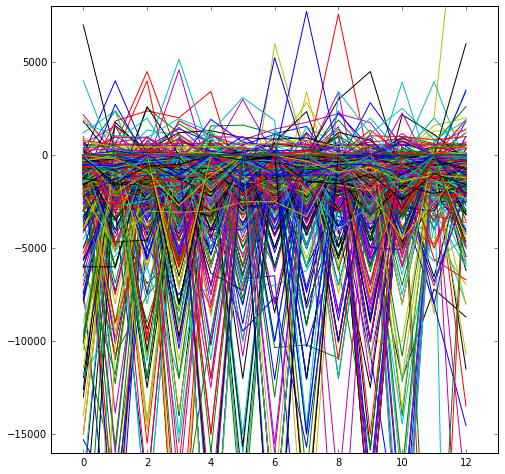

In [54]:
plt.figure(figsize=(8,8))
for k in np.arange(accountcluster11.shape[0]):
        plt.plot(accountcluster11[k])
plt.ylim(-16000,8000)
plt.xlim(-1,13)
plt.show()

(573, 13)


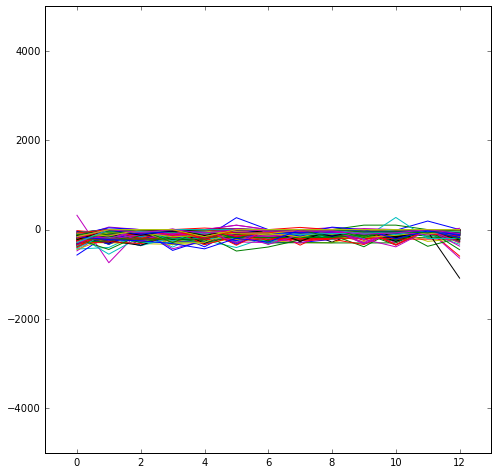

Iteracio: 1
-198.0 [-20.87391878]
[-107.38900043] [ 65.64116288]
[-190.44347882] [ 148.69564127]
158.015821993
Iteracio: 12
-131.0 [-14.25000116]
[-52.56546204] [ 24.06545973]
[-89.34830449] [ 60.84830217]
69.8856208386
Iteracio: 23
-594.0 [-17.25]
[-77.87996142] [ 43.37996142]
[-136.08472439] [ 101.58472439]
90.1997782702
Iteracio: 33
-127.0 [-48.27270856]
[-88.30021632] [-8.2452008]
[-126.72662377] [ 30.18120665]
117.345643294
Iteracio: 86
0.0 [-126.5]
[-178.90591884] [-74.09408116]
[-229.21560092] [-23.78439908]
99.2421281513
Iteracio: 105
-241.0 [-62.125]
[-116.48937234] [-7.76062766]
[-168.67916978] [ 44.42916979]
169.032541246
Iteracio: 111
-193.0 [-20.625]
[-94.06681173] [ 52.81681173]
[-164.57095099] [ 123.32095099]
135.033329219
Iteracio: 137
-640.0 [-19.12499889]
[-133.4817009] [ 95.23170312]
[-243.26413482] [ 205.01413705]
211.860803359
Iteracio: 165
-242.0 [-11.62500008]
[-68.82639957] [ 45.57639941]
[-123.73974308] [ 100.48974292]
70.1141925718
Iteracio: 173
0.0 [-284.]
[-

array([ 0.61281709])

In [35]:
#Llegim les comptes del 12è cluster
accountcluster12=np.zeros((len(assignmentsclus[11]),13))
for i in np.arange(len(assignmentsclus[11])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster12[i]=accountclean[assignmentsclus[11][i].astype(int)]

print accountcluster12.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster12.shape[0]):
        plt.plot(accountcluster12[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 105.0**2 * RBF(length_scale=22.5)  # long term smooth rising trend
#k2 = 12.0**2 * RBF(length_scale=10.0) * ExpSineSquared(length_scale=9.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=12.5**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp12 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster12,accountcluster12.shape[0],gp12,11)

(2163, 13)


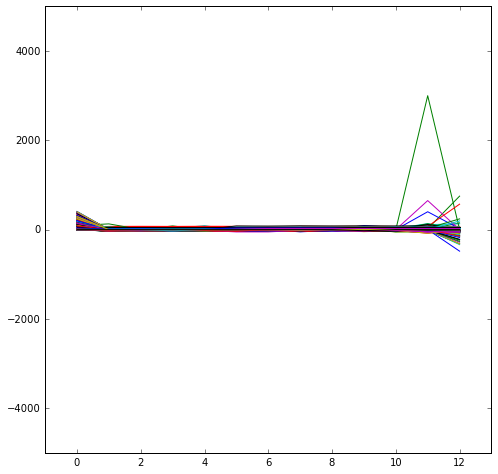

Iteracio: 35
0.0 [-15.75000008]
[-23.54422897] [-7.9557712]
[-31.0266887] [-0.47331147]
25.7681974535
Iteracio: 54
-30.0 [-9.37500001]
[-19.29677913] [ 0.54677911]
[-28.82168708] [ 10.07168706]
25.5929677841
Iteracio: 55
-320.0 [-13.5]
[-22.50000228] [-4.49999772]
[-31.14000446] [ 4.14000446]
32.1869538789
Iteracio: 77
-44.0 [ 0.]
[-9.48079678] [ 9.48079678]
[-18.58236169] [ 18.58236169]
31.0805405358
Iteracio: 111
-20.0 [ 0.]
[-8.66026947] [ 8.66026947]
[-16.97412815] [ 16.97412815]
8.48528137424
Iteracio: 120
-57.0 [ 0.]
[-4.96078709] [ 4.96078709]
[-9.7231427] [ 9.7231427]
1.0
Iteracio: 125
-29.0 [-10.87500007]
[-17.45650733] [-4.29349281]
[-23.7747543] [ 2.02475416]
38.5486705348
Iteracio: 149
-19.0 [-0.66120589]
[-7.78511196] [ 6.46270018]
[-14.62406178] [ 13.30165001]
16.8522995464
Iteracio: 157
18.0 [ 0.]
[-6.61437834] [ 6.61437834]
[-12.96418154] [ 12.96418154]
20.8806130178
Iteracio: 166
-40.0 [ 0.]
[-6.61438129] [ 6.61438129]
[-12.96418733] [ 12.96418733]
6.0
Iteracio: 182
-2

Iteracio: 1137
-57.0 [ 0.]
[-9.12984373] [ 9.12984373]
[-17.89449372] [ 17.89449372]
10.295630141
Iteracio: 1142
-26.0 [ 0.]
[-8.26795129] [ 8.26795129]
[-16.20518454] [ 16.20518454]
11.0
Iteracio: 1145
-50.0 [ 0.]
[-5.99054947] [ 5.99054947]
[-11.74147695] [ 11.74147695]
17.4642491966
Iteracio: 1146
-20.0 [ 0.]
[-7.4030128] [ 7.4030128]
[-14.50990509] [ 14.50990509]
18.4661853126
Iteracio: 1161
-74.0 [ 0.]
[-16.60525063] [ 16.60525063]
[-32.54629123] [ 32.54629123]
49.3659801888
Iteracio: 1180
-283.0 [ 0.]
[-3.96863342] [ 3.96863342]
[-7.77852151] [ 7.77852151]
2.0
Iteracio: 1193
-25.0 [-0.4999974]
[-8.76118491] [ 7.76119011]
[-16.69192492] [ 15.69193012]
13.638181697
Iteracio: 1232
-19.0 [ 0.]
[-7.93725645] [ 7.93725645]
[-15.55702265] [ 15.55702265]
10.0
Iteracio: 1245
-25.0 [ 0.]
[-10.26827736] [ 10.26827736]
[-20.12582363] [ 20.12582363]
20.1990098767
Iteracio: 1264
-24.0 [ 0.]
[-8.03943391] [ 8.03943391]
[-15.75729046] [ 15.75729046]
29.0688837075
Iteracio: 1267
-23.0 [ 0.]
[-10.

array([ 0.38967707])

In [71]:
#Llegim les comptes del 13è cluster
accountcluster13=np.zeros((len(assignmentsclus[12]),13))
for i in np.arange(len(assignmentsclus[12])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster13[i]=accountclean[assignmentsclus[12][i].astype(int)]

print accountcluster13.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster13.shape[0]):
        plt.plot(accountcluster13[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 65.0**2 * RBF(length_scale=25.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 3.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp13 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster13,accountcluster13.shape[0],gp13,12)

(1092, 13)


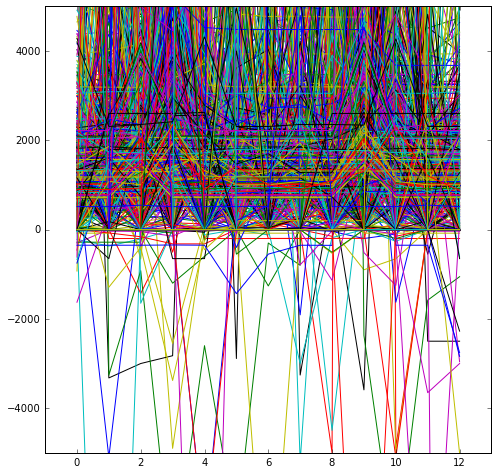

Iteracio: 27
3000.0 [ 203.75]
[-428.70553203] [ 836.20553203]
[-1035.86284279] [ 1443.36284279]
3601.25019958
Iteracio: 31
1643.0 [ 2946.5]
[ 2314.04446797] [ 3578.95553203]
[ 1706.88715721] [ 4186.11284279]
5129.89317628
Iteracio: 42
18390.0 [ 1058.99999995]
[ 426.54446791] [ 1691.45553198]
[-180.61284284] [ 2298.61284273]
15355.6311821
Iteracio: 49
26000.0 [ 0.]
[-547.72255767] [ 547.72255767]
[-1073.53621303] [ 1073.53621303]
19256.1420591
Iteracio: 70
85160.0 [ 30403.75]
[ 29771.29446797] [ 31036.20553203]
[ 29164.13715721] [ 31643.36284279]
206822.309993
Iteracio: 72
12589.0 [ 1254.625]
[ 622.16946797] [ 1887.08053203]
[ 15.01215721] [ 2494.23784279]
17402.4585332
Iteracio: 75
1492.0 [ 1134.375]
[ 1030.80022354] [ 1237.94977646]
[ 931.36843814] [ 1337.38156186]
2949.37976531
Iteracio: 79
0.0 [ 1895.]
[ 1347.27744249] [ 2442.72255751]
[ 821.46378727] [ 2968.53621273]
2487.96905125
Iteracio: 83
-2500.0 [ 2711.]
[ 2078.54446797] [ 3343.45553203]
[ 1471.38715721] [ 3950.61284279]
3995

Iteracio: 572
0.0 [ 2663.875]
[ 2116.15244249] [ 3211.59755751]
[ 1590.33878727] [ 3737.41121273]
4877.77367249
Iteracio: 584
-614.0 [ 925.]
[ 377.27744249] [ 1472.72255751]
[-148.53621273] [ 1998.53621273]
4091.622661
Iteracio: 590
2277.0 [ 921.75000374]
[ 289.29447171] [ 1554.20553578]
[-317.86283904] [ 2161.36284653]
2958.11443322
Iteracio: 592
-73000.0 [ 318.25]
[-229.47255751] [ 865.97255751]
[-755.28621273] [ 1391.78621273]
4555.46583787
Iteracio: 593
5354.0 [ 2798.375]
[ 2165.91946797] [ 3430.83053203]
[ 1558.76215721] [ 4037.98784279]
8213.2796738
Iteracio: 595
3720.0 [ 5531.99999113]
[ 4899.54445909] [ 6164.45552316]
[ 4292.38714834] [ 6771.61283391]
20410.5705457
Iteracio: 601
36388.0 [ 28636.40545652]
[ 28003.94992449] [ 29268.86098856]
[ 27396.79261374] [ 29876.01829931]
145737.770369
Iteracio: 603
31262.0 [ 9658.875]
[ 9026.41946797] [ 10291.33053203]
[ 8419.26215721] [ 10898.48784279]
70118.293255
Iteracio: 627
0.0 [ 1354.875]
[ 722.41946797] [ 1987.33053203]
[ 115.262157

array([ 0.53715924])

In [36]:
#Llegim les comptes del 14è cluster
accountcluster14=np.zeros((len(assignmentsclus[13]),13))
for i in np.arange(len(assignmentsclus[13])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster14[i]=accountclean[assignmentsclus[13][i].astype(int)]

print accountcluster14.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster14.shape[0]):
        plt.plot(accountcluster14[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 9050.0**2 * RBF(length_scale=955.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2=85*ExpSineSquared(length_scale=35.0, periodicity=4.0)
k3 = 135.5**2* RationalQuadratic(length_scale=67.0, alpha=1.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=45.6**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp14 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster14,accountcluster14.shape[0],gp14,13)

(1092, 13)


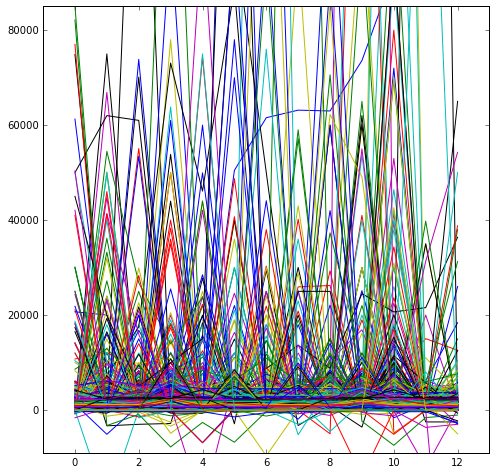

In [29]:
accountcluster14=np.zeros((len(assignmentsclus[13]),13))
for i in np.arange(len(assignmentsclus[13])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster14[i]=accountclean[assignmentsclus[13][i].astype(int)]

print accountcluster14.shape


plt.figure(figsize=(8,8))
for k in np.arange(accountcluster14.shape[0]):
        plt.plot(accountcluster14[k])
plt.ylim(-9000,85000)
plt.xlim(-1,13)
plt.show()

(2657, 13)


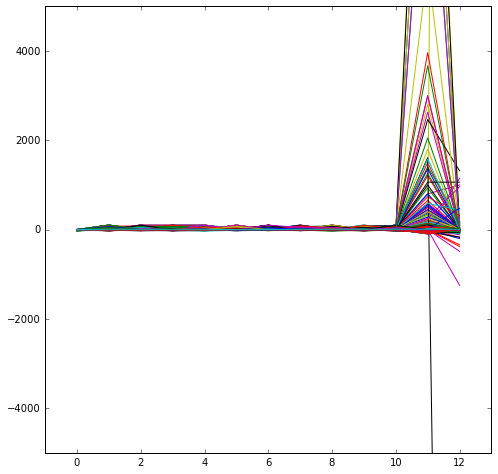

Iteracio: 6
-40.0 [-3.37499998]
[-10.990778] [ 4.24077804]
[-18.3019249] [ 11.55192495]
16.0934769394
Iteracio: 53
-98.0 [ 0.]
[-1.32287569] [ 1.32287569]
[-2.59283636] [ 2.59283636]
10.0995049384
Iteracio: 75
0.0 [-13.75]
[-18.79076155] [-8.70923845]
[-23.62989264] [-3.87010736]
29.4448637287
Iteracio: 83
-12.0 [-8.]
[-9.65361292] [-6.34638708]
[-11.24108132] [-4.75891868]
24.8797106092
Iteracio: 90
-12.0 [-3.125]
[-7.51248448] [ 1.26248448]
[-11.72446958] [ 5.47446959]
11.2249721603
Iteracio: 95
1000.0 [ 0.]
[-264.57513146] [ 264.57513146]
[-518.56725767] [ 518.56725767]
800.093744507
Iteracio: 107
106.0 [ 0.]
[-27.14053268] [ 27.14053268]
[-53.19544405] [ 53.19544405]
87.4013729869
Iteracio: 118
-79.0 [-3.625]
[-10.77955193] [ 3.52955193]
[-17.64792179] [ 10.39792179]
17.4928556845
Iteracio: 119
-72.0 [-0.625]
[-3.27075131] [ 2.02075131]
[-5.81067258] [ 4.56067258]
9.11043357914
Iteracio: 138
-14.0 [-1.74999985]
[-5.13885947] [ 1.63885977]
[-8.3921647] [ 4.89216501]
6.78232998313
It

Iteracio: 1408
0.0 [-9.50000001]
[-13.18246256] [-5.81753745]
[-16.71762661] [-2.28237341]
17.9164728672
Iteracio: 1435
0.0 [-6.]
[-8.09410354] [-3.90589646]
[-10.10444294] [-1.89555706]
11.5758369028
Iteracio: 1470
-40.0 [ 0.]
[-13.22876461] [ 13.22876461]
[-25.92837863] [ 25.92837863]
41.8330013267
Iteracio: 1495
-53.0 [ 0.]
[-9.59085062] [ 9.59085062]
[-18.79806722] [ 18.79806722]
31.4801524774
Iteracio: 1527
-5.0 [-2.]
[-3.39194018] [-0.60805982]
[-4.72820275] [ 0.72820275]
9.64365076099
Iteracio: 1530
160.0 [ 0.]
[-33.07189505] [ 33.07189505]
[-64.8209143] [ 64.8209143]
100.747208398
Iteracio: 1540
-14.0 [-0.12499993]
[-2.10931385] [ 1.85931399]
[-4.01425521] [ 3.76425535]
7.21110255093
Iteracio: 1557
-69.0 [ 0.]
[-11.24444311] [ 11.24444311]
[-22.0391085] [ 22.0391085]
36.1386219992
Iteracio: 1558
100.0 [ 0.]
[-6.61437834] [ 6.61437834]
[-12.96418154] [ 12.96418154]
23.4520787991
Iteracio: 1568
0.0 [-15.125]
[-21.28551931] [-8.96448069]
[-27.19961784] [-3.05038215]
34.1760149813


array([ 3.35447995])

In [74]:
#Llegim les comptes del 15è cluster
accountcluster15=np.zeros((len(assignmentsclus[14]),13))
for i in np.arange(len(assignmentsclus[14])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster15[i]=accountclean[assignmentsclus[14][i].astype(int)]

print accountcluster15.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster15.shape[0]):
        plt.plot(accountcluster15[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 140.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0)* ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2=25*ExpSineSquared(length_scale=2.0, periodicity=3.0)* 7.5*DotProduct(sigma_0=5.0)  
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2* RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp15 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=1e-6,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster15,accountcluster15.shape[0],gp15,14)

(2657, 13)


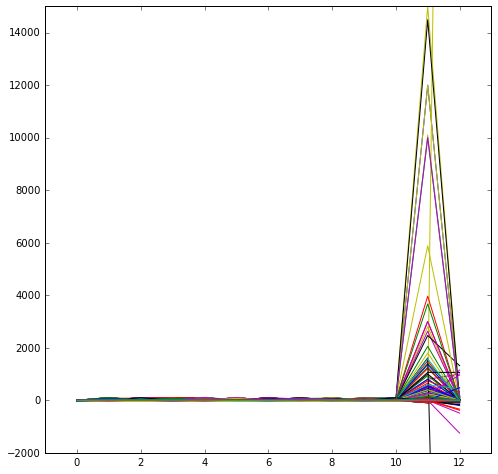

In [32]:
#Llegim les comptes del 15è cluster
accountcluster15=np.zeros((len(assignmentsclus[14]),13))
for i in np.arange(len(assignmentsclus[14])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster15[i]=accountclean[assignmentsclus[14][i].astype(int)]

print accountcluster15.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster15.shape[0]):
        plt.plot(accountcluster15[k])
plt.ylim(-2000,15000)
plt.xlim(-1,13)
plt.show()

(261, 13)


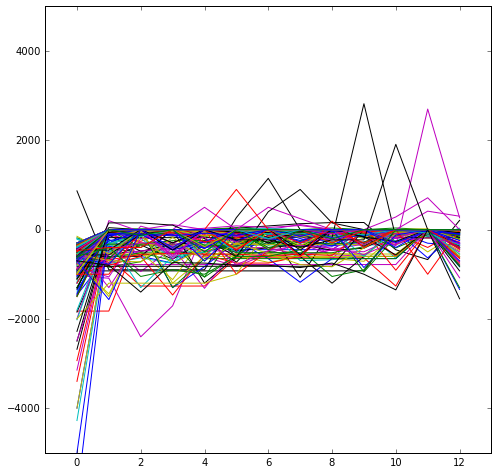

Iteracio: 5
-28.0 [-329.76087655]
[-444.80425302] [-214.71750008]
[-555.24589443] [-104.27585867]
368.206463822
Iteracio: 110
0.0 [-339.49566991]
[-451.69665791] [-227.29468192]
[-559.40960639] [-119.58173344]
339.169574107
Iteracio: 186
-1080.0 [-33.75]
[-455.97176319] [ 388.47176319]
[-861.30465584] [ 793.80465584]
906.324445218
Iteracio: 193
-722.0 [-103.24999998]
[-363.45878461] [ 156.95878464]
[-613.25921785] [ 406.75921789]
498.224848838
Iteracio: 213
-550.0 [-49.99999585]
[-292.38400115] [ 192.38400945]
[-525.07264623] [ 425.07265453]
465.007526821
La predicció de compte en negatiu en predicció i real correctes és de: 0.655172413793
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.973180076628
La predicció de compte esta compresa en la zona determinada: 0.908045977011
La predicció de compte ens permet assegurar el signe final: 0.980842911877
Comptes signe 0.781609195402
The Mean Absolute Scaled error is [ 0.45220002]
The MAE error is [ 80.15977345]
Th

array([ 0.45220002])

In [75]:
#Llegim les comptes del 16è cluster
accountcluster16=np.zeros((len(assignmentsclus[15]),13))
for i in np.arange(len(assignmentsclus[15])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster16[i]=accountclean[assignmentsclus[15][i].astype(int)]

print accountcluster16.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster16.shape[0]):
        plt.plot(accountcluster16[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 120.0**2 * RBF(length_scale=60.0)*DotProduct(sigma_0=5.0)   # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 3.5**2* RationalQuadratic(length_scale=12.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=12.0**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp16 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster16,accountcluster16.shape[0],gp16,15)

(1316, 13)


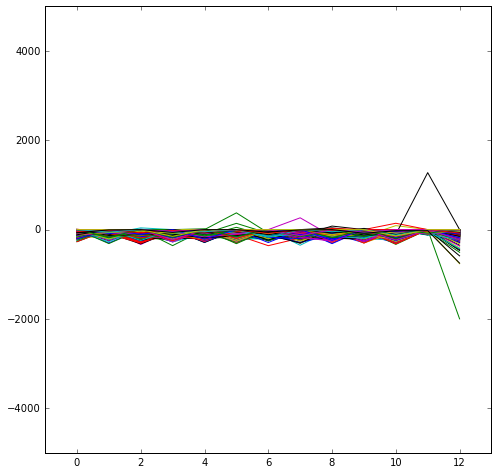

Iteracio: 52
-157.0 [-26.375]
[-68.94185908] [ 16.19185908]
[-109.8060438] [ 57.0560438]
108.314357312
Iteracio: 208
-137.0 [-22.125]
[-70.67890937] [ 26.42890937]
[-117.29066237] [ 73.04066237]
53.9351462406
Iteracio: 216
-350.0 [-43.75]
[-131.25002868] [ 43.75002868]
[-215.2500562] [ 127.7500562]
202.170719937
Iteracio: 274
-260.0 [-71.25]
[-144.36403975] [ 1.86403975]
[-214.55351791] [ 72.05351791]
151.891408579
Iteracio: 299
-120.0 [-36.5]
[-77.80073301] [ 4.80073301]
[-117.44943671] [ 44.44943671]
99.8649087518
Iteracio: 313
-413.0 [-36.25]
[-133.4967735] [ 60.9967735]
[-226.85367605] [ 154.35367605]
205.919887335
Iteracio: 328
-143.0 [-17.875]
[-80.66985108] [ 44.91985108]
[-140.95290812] [ 105.20290812]
101.168176815
Iteracio: 342
-469.0 [-24.125]
[-66.12640987] [ 17.87640987]
[-106.44776334] [ 58.19776334]
53.1507290637
Iteracio: 354
-163.0 [-49.125]
[-100.88405712] [ 2.63405712]
[-150.57275196] [ 52.32275196]
104.307238483
Iteracio: 358
-226.0 [-55.]
[-133.45131746] [ 23.45131

Iteracio: 1226
-207.0 [-16.49999999]
[-95.53076372] [ 62.53076373]
[-171.4002969] [ 138.40029691]
175.168490317
Iteracio: 1240
-109.0 [-23.875]
[-67.17626662] [ 19.42626662]
[-108.74548257] [ 60.99548257]
57.3410847473
Iteracio: 1244
-132.0 [-16.4999995]
[-73.65767741] [ 40.65767842]
[-128.5290482] [ 95.52904921]
90.1498752079
Iteracio: 1287
-149.0 [-38.87499902]
[-80.31601778] [ 2.56601973]
[-120.09939578] [ 42.34939774]
108.503456166
Iteracio: 1302
-184.0 [-15.99999466]
[-78.73555086] [ 46.73556153]
[-138.96168481] [ 106.96169548]
98.0561063881
Iteracio: 1311
-78.0 [-18.09332375]
[-48.42305224] [ 12.23640474]
[-77.53959159] [ 41.35294409]
64.784257347
Iteracio: 1315
-751.0 [-24.375]
[-55.32656793] [ 6.57656793]
[-85.04007314] [ 36.29007314]
87.0631954387
La predicció de compte en negatiu en predicció i real correctes és de: 0.496200607903
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.999240121581
La predicció de compte esta compresa en la zona determina

array([ 0.62799599])

In [76]:
#Llegim les comptes del 17è cluster
accountcluster17=np.zeros((len(assignmentsclus[16]),13))
for i in np.arange(len(assignmentsclus[16])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster17[i]=accountclean[assignmentsclus[16][i].astype(int)]

print accountcluster17.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster17.shape[0]):
        plt.plot(accountcluster17[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k2=12.0*ExpSineSquared(length_scale=2.0, periodicity=4.0)
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp17 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster17,accountcluster17.shape[0],gp17,16)

(2000, 13)


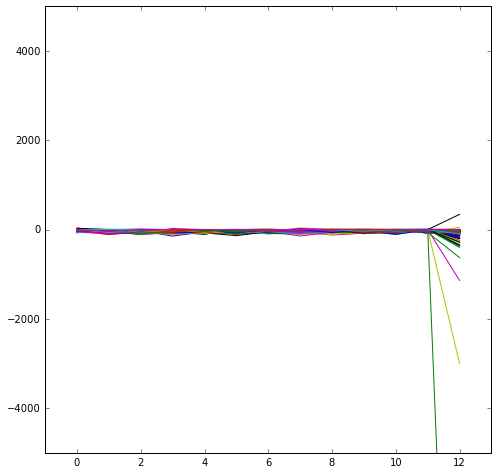

Iteracio: 2
-50.0 [ 0.]
[-10.91372599] [ 10.91372599]
[-21.39090294] [ 21.39090294]
12.0
Iteracio: 34
-361.0 [-4.5]
[-30.79372252] [ 21.79372252]
[-56.03569614] [ 47.03569614]
43.0464865001
Iteracio: 42
-82.0 [ 0.]
[-22.48952249] [ 22.48952249]
[-44.07946407] [ 44.07946407]
23.0
Iteracio: 46
-1139.0 [ 0.]
[-11.24444736] [ 11.24444736]
[-22.03911682] [ 22.03911682]
11.0
Iteracio: 48
-33.0 [-4.25]
[-16.96564707] [ 8.46564707]
[-29.17266825] [ 20.67266825]
25.3377189186
Iteracio: 72
-100.0 [-5.]
[-32.83882121] [ 22.83882121]
[-59.56408957] [ 49.56408957]
80.1560977094
Iteracio: 82
0.0 [-43.00000066]
[-64.59137591] [-21.4086254]
[-85.31909615] [-0.68090516]
51.2445119013
Iteracio: 115
-135.0 [ 0.]
[-16.60650649] [ 16.60650649]
[-32.54875272] [ 32.54875272]
20.3960780544
Iteracio: 123
-206.0 [ 0.]
[-10.25228682] [ 10.25228682]
[-20.09448216] [ 20.09448216]
14.0
Iteracio: 130
-41.0 [ 0.]
[-16.20523959] [ 16.20523959]
[-31.7622696] [ 31.7622696]
4.0
Iteracio: 131
-291.0 [ 0.]
[-12.89804423] [

Iteracio: 1380
-255.0 [ 0.]
[-16.20522757] [ 16.20522757]
[-31.76224604] [ 31.76224604]
4.0
Iteracio: 1419
-72.0 [ 0.]
[-17.85882246] [ 17.85882246]
[-35.00329202] [ 35.00329202]
9.0
Iteracio: 1423
-43.0 [ 0.]
[-14.22092534] [ 14.22092534]
[-27.87301368] [ 27.87301368]
2.0
Iteracio: 1486
-68.0 [ 0.]
[-20.50466894] [ 20.50466894]
[-40.18915111] [ 40.18915111]
17.0
Iteracio: 1498
-55.0 [-2.125]
[-25.27548842] [ 21.02548842]
[-47.49995731] [ 43.24995731]
30.2324329157
Iteracio: 1533
0.0 [-52.625]
[-76.76206694] [-28.48793306]
[-99.9336512] [-5.3163488]
73.4914961067
Iteracio: 1535
-53.0 [ 0.]
[-16.53594965] [ 16.53594965]
[-32.41046132] [ 32.41046132]
5.0
Iteracio: 1543
-85.0 [ 0.]
[-18.85107356] [ 18.85107356]
[-36.94810418] [ 36.94810418]
12.0
Iteracio: 1566
-77.0 [-4.25]
[-23.86504508] [ 15.36504508]
[-42.69548835] [ 34.19548835]
37.8153408024
Iteracio: 1569
-628.0 [-15.125]
[-45.62503145] [ 15.37503145]
[-74.90506164] [ 44.65506164]
68.6585755751
Iteracio: 1588
-56.0 [ 0.]
[-12.236604

array([ 0.98730527])

In [77]:
#Llegim les comptes del 18è cluster
accountcluster18=np.zeros((len(assignmentsclus[17]),13))
for i in np.arange(len(assignmentsclus[17])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster18[i]=accountclean[assignmentsclus[17][i].astype(int)]

print accountcluster18.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster18.shape[0]):
        plt.plot(accountcluster18[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
#k2= 0.4*DotProduct(sigma_0=1.0)
k3 = 1.5**2* RationalQuadratic(length_scale=2.0, alpha=0.65)
k4 = 2.8**2 * RBF(length_scale=0.8) \
    + WhiteKernel(noise_level=0.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp18 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster18,accountcluster18.shape[0],gp18,17)

(1030, 13)


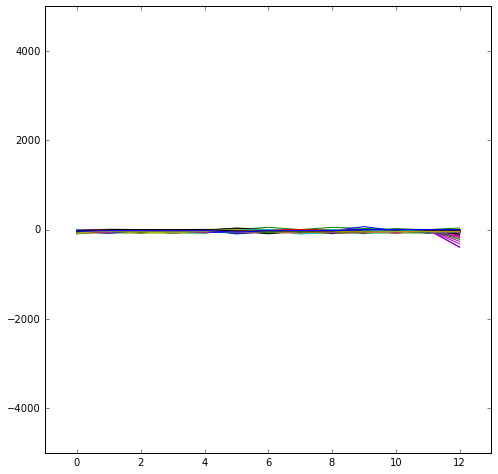

Iteracio: 46
-155.0 [-34.12499881]
[-51.12821676] [-17.12178086]
[-67.45130599] [-0.79869163]
58.8132638101
Iteracio: 53
-32.0 [-5.375]
[-16.21188795] [ 5.46188795]
[-26.61530037] [ 15.86530037]
27.5317997959
Iteracio: 72
-60.0 [-20.00000001]
[-35.03277658] [-4.96722344]
[-49.46424209] [ 9.46424207]
47.0106370942
Iteracio: 76
0.0 [-22.375]
[-32.89879758] [-11.85120242]
[-43.00164325] [-1.74835675]
31.0483493925
Iteracio: 119
0.0 [-18.49936884]
[-27.51238624] [-9.48635144]
[-36.16488295] [-0.83385474]
38.0657326213
Iteracio: 135
0.0 [-36.3771964]
[-48.65051129] [-24.10388151]
[-60.43289358] [-12.32149921]
37.6563407675
Iteracio: 138
0.0 [-28.3750001]
[-40.75090396] [-15.99909624]
[-52.63177166] [-4.11822854]
28.2842712475
Iteracio: 155
0.0 [-25.37498113]
[-38.26907102] [-12.48089124]
[-50.64739732] [-0.10256494]
27.3861278753
Iteracio: 159
-33.0 [-53.9445547]
[-64.51500475] [-43.37410465]
[-74.6626368] [-33.22647259]
82.036577208
Iteracio: 160
-34.0 [-4.24999894]
[-18.97243154] [ 10.472

array([ 0.52135644])

In [78]:
#Llegim les comptes del 19è cluster
accountcluster19=np.zeros((len(assignmentsclus[18]),13))
for i in np.arange(len(assignmentsclus[18])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster19[i]=accountclean[assignmentsclus[18][i].astype(int)]

print accountcluster19.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster19.shape[0]):
        plt.plot(accountcluster19[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 1.5**2* RationalQuadratic(length_scale=5.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=1.8**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp19 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster19,accountcluster19.shape[0],gp19,18)

(1652, 13)


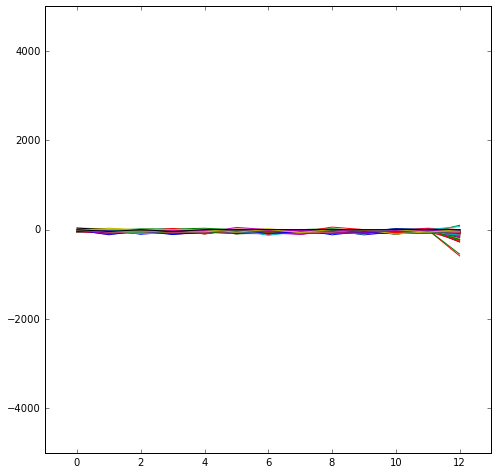

Iteracio: 6
0.0 [-90.01872789]
[-116.72050074] [-63.31695505]
[-142.35420267] [-37.68325312]
75.6372923894
Iteracio: 8
-66.0 [-9.74999991]
[-25.20962614] [ 5.70962632]
[-40.05086733] [ 20.55086751]
43.0348695827
Iteracio: 34
-123.0 [-16.75000001]
[-49.05300926] [ 15.55300925]
[-80.06389815] [ 46.56389814]
79.4418025979
Iteracio: 49
-140.0 [-5.49998487]
[-25.90679372] [ 14.90682398]
[-45.49733021] [ 34.49736048]
16.3401346384
Iteracio: 53
-80.0 [-10.99999919]
[-35.710501] [ 13.71050262]
[-59.43258274] [ 37.43258436]
42.3438307195
Iteracio: 56
0.0 [-54.96183954]
[-78.61008526] [-31.31359382]
[-101.31240115] [-8.61127793]
82.2860863087
Iteracio: 81
-96.0 [-5.12499231]
[-27.5024645] [ 17.25247987]
[-48.9848378] [ 38.73485318]
24.3721152139
Iteracio: 87
-91.0 [-8.12499975]
[-25.78806147] [ 9.53806197]
[-42.74460071] [ 26.49460121]
44.7101778122
Iteracio: 90
-62.0 [-4.37499754]
[-30.20497243] [ 21.45497736]
[-55.00174833] [ 46.25175326]
38.6910842443
Iteracio: 131
0.0 [-53.125]
[-78.134686] 

/Users/gerardmartinezcanelles/anaconda2/lib/python2.7/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -1.83547256e-05,  -0.00000000e+00,   1.04050457e-07,
        -3.46814744e-06,  -5.52979330e-07,  -1.83547256e-05,
        -0.00000000e+00,  -1.83547256e-05]), 'nit': 12, 'funcalls': 60}
  " state: %s" % convergence_dict)


Iteracio: 541
0.0 [-35.62500005]
[-52.58079336] [-18.66920674]
[-68.85835494] [-2.39164517]
53.8052042093
Iteracio: 569
-184.0 [-18.75000054]
[-48.44832179] [ 10.9483207]
[-76.95871018] [ 39.45870909]
75.126559884
Iteracio: 583
-180.0 [-5.]
[-33.71819388] [ 23.71819388]
[-61.28766] [ 51.28766]
46.6261729075
Iteracio: 588
-68.0 [-12.94315558]
[-40.44970423] [ 14.56339307]
[-66.85599093] [ 40.96967977]
56.5420197729
Iteracio: 589
-49.0 [-2.50000006]
[-16.6421391] [ 11.64213898]
[-30.21859258] [ 25.21859245]
27.3313007374
Iteracio: 615
-42.0 [-6.75]
[-20.73593896] [ 7.23593896]
[-34.16244036] [ 20.66244035]
20.7123151772
Iteracio: 635
-146.0 [-2.75]
[-13.96104347] [ 8.46104347]
[-24.7236452] [ 19.2236452]
23.4307490277
Iteracio: 682
-64.0 [-12.25]
[-36.86933306] [ 12.36933306]
[-60.5038928] [ 36.0038928]
52.990565198
Iteracio: 689
-50.0 [-11.12494162]
[-30.83496024] [ 8.585077]
[-49.75657812] [ 27.50669487]
41.0243829935
Iteracio: 700
-274.0 [-8.25]
[-39.09565311] [ 22.59565311]
[-68.7074

Iteracio: 1639
-43.0 [-5.75]
[-19.52567551] [ 8.02567551]
[-32.750324] [ 21.250324]
64.5290632196
Iteracio: 1640
-70.0 [-16.5]
[-41.15015266] [ 8.15015266]
[-64.81429922] [ 31.81429922]
54.5985347789
La predicció de compte en negatiu en predicció i real correctes és de: 0.427966101695
La predicció de compte en negatiu en predicció i real o 0 correctes és de: 0.992736077482
La predicció de compte esta compresa en la zona determinada: 0.800847457627
La predicció de compte ens permet assegurar el signe final: 0.928571428571
Comptes signe 0.985472154964
The Mean Absolute Scaled error is [ 0.56009672]
The MAE error is [ 16.54970459]
The RMSE is [ 36.3317971]


array([ 0.56009672])

In [79]:
#Llegim les comptes del 20è cluster
accountcluster20=np.zeros((len(assignmentsclus[19]),13))
for i in np.arange(len(assignmentsclus[19])):
    #print data1[centroidscent[i].astype(int)]
    accountcluster20[i]=accountclean[assignmentsclus[19][i].astype(int)]

print accountcluster20.shape

plt.figure(figsize=(8,8))
for k in np.arange(accountcluster20.shape[0]):
        plt.plot(accountcluster20[k])
plt.ylim(-5000,5000)
plt.xlim(-1,13)
plt.show()

# Kernel with parameters 
k1 = 40.0**2 * RBF(length_scale=20.0)  # long term smooth rising trend
#k2 = 3.0**2 * RBF(length_scale=10.0) \
#    * ExpSineSquared(length_scale=2.0, periodicity=4.0)  # seasonal component
# medium term irregularity
k3 = 12**2* RationalQuadratic(length_scale=8.0, alpha=0.5)
k4 = 0.5**2 * RBF(length_scale=0.3) \
    + WhiteKernel(noise_level=10.2**2)  # noise terms
kernel_gpmlini = k1+k3+k4


gp20 = GaussianProcessRegressor(kernel=kernel_gpmlini, alpha=0,
                              optimizer='fmin_l_bfgs_b', n_restarts_optimizer=1, normalize_y=True)
regressionaccounts(3,accountcluster20,accountcluster20.shape[0],gp20,19)

In [120]:
aerggt=np.zeros((2,4))
aerggt[0]=np.array([1 2 3 4])
aerggt[1]=np.array([1,4,3,4])

SyntaxError: invalid syntax (<ipython-input-120-4085106cf73c>, line 2)

In [114]:
aerggt

array([[ 1.,  2.,  3.,  4.],
       [ 1.,  4.,  3.,  4.]])

In [115]:
aerggt[0]

array([ 1.,  2.,  3.,  4.])

In [38]:
def regression1(accountclean,quant,gp,clusternum):
    #np.arange(accountclean.shape[0])
    a=np.arange(12)+1 #vector del 1 al 12
    a=a.reshape(-1,1)
    xs=np.arange(13,14,1).reshape(-1,1) #vector que conte el 13
    compt=0
    compt1=0
    compt2=0
    compt3=0
    errort=0
    errorrmse=0
    denom=0
    errormae=0
    lambd=10
    mase=0
    for i in np.arange(quant):
        error=0
        gp.fit(a, accountclean[i][0:12])
        print i
        #print("GPML kernel: %s" % gp.kernel_)
        #print("Log-marginal-likelihood: %.3f"
        #   %gp.log_marginal_likelihood(gp.kernel_.theta))
        y_pred, sigmapred = gp.predict(xs, return_std=True)
        print accountclean[i][12], y_pred
        if (accountclean[i][12]<0 and y_pred<0) or (accountclean[i][12]>0 and y_pred>0) or (accountclean[i][12]==0 and y_pred==0):
            compt+=1
        if (accountclean[i][12]<=0 and y_pred<0) or (accountclean[i][12]>0 and y_pred>0) or (accountclean[i][12]==0 and y_pred==0):
            compt1+=1
        if (accountclean[i][12]<=(y_pred+sigmapred)) and ((accountclean[i][12]>=(y_pred-sigmapred))) or (np.abs((accountclean[i][12]-y_pred))<=1e-2):
            compt2+=1 
        if (accountclean[i][12]<=(y_pred+1.9600*sigmapred)) and ((accountclean[i][12]>=(y_pred-1.9600*sigmapred))) or (np.abs((accountclean[i][12]-y_pred))<=1e-1):
            compt3+=1
        #print compt1
        error=np.abs(y_pred-accountclean[i][12])
        denom=np.sum(np.abs(np.asarray([t - s for s, t in zip(accountclean[i], accountclean[i][1:12])][:]))) #naive
        errort+=error/float((denom/float(11))+lambd)
        errorrmse+=error**2
        errormae+=error
    
    mae=errormae/float(quant)    
    mase=errort/float(quant)
    rmse=np.sqrt(errorrmse/float(quant)) 
    print 'La predicció de compte en negatiu en predicció i real correctes és de:',compt/float(quant)
    print 'La predicció de compte en negatiu en predicció i real o 0 correctes és de:',compt1/float(quant)
    print 'La predicció de compte esta compresa en la zona indeterminada:',compt2/float(quant)  
    print 'La predicció de compte ens permet assegurar el signe final:',compt3/float(quant)
    print 'The Mean Absolute Scaled error is',mase 
    print 'The MAE error is',mae
    print 'The RMSE is',rmse